# Larvae classification

## 1. Definitions

In [1]:
from pathlib import Path

import torch
from dataset import ImageDataLoadBuilder, visualize_larvae_sample
from visualize import Visualizer
from metrics import f1_fn, cohen_kappa_fn
from models import FlexCNNClassifier
from torch import nn, optim
from torchsummary import summary
from torchvision import transforms
from training import Trainer

In [2]:
device = torch.device(0) if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


In [3]:
width = 224
height = 224
nchannels = 3
input_size = (height, width)
input_shape = (nchannels, height, width)
num_classes = 2
imagenet_mean, imagenet_std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
labels_map = {
    0: "Larvae",
    1: "Non-larvae",
}

## 2. Data ETL

In [4]:
# Regular preprocessing transformation
preparation = transforms.Compose(
    [
        transforms.Resize(
            input_size,
            interpolation=transforms.InterpolationMode.BILINEAR,
            max_size=None,
            antialias=True,
        ),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]
)

# Data augmentation transformation
augmentation = transforms.Compose(
    [
        transforms.Resize(
            (300, 300),
            interpolation=transforms.InterpolationMode.BILINEAR,
            max_size=None,
            antialias=True,
        ),
        transforms.RandomAffine(
            degrees=10,
            translate=(0.05, 0.10),
            scale=(0.9, 1.1),
            shear=(-2, 2),
            interpolation=transforms.InterpolationMode.BILINEAR,
            fill=0,
        ),
        transforms.CenterCrop(250),
        preparation,
    ]
)

In [5]:
builder = ImageDataLoadBuilder(
    data_dir=Path("./images/larvae"),
    train_transform=augmentation,
    valid_transform=preparation,
    test_transform=preparation,
)
train_loader, valid_loader, test_loader = builder.get_tvt_splited_dataloaders()

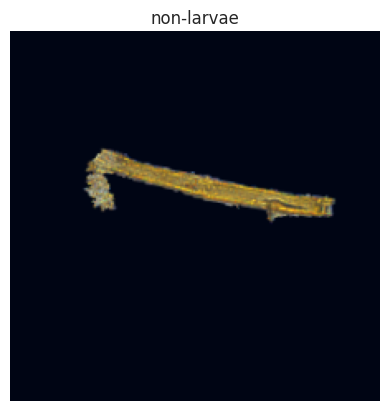

In [6]:
visualize_larvae_sample(train_loader.dataset)

In [7]:
len(train_loader.dataset), len(valid_loader.dataset), len(test_loader.dataset)

(798, 320, 480)

## 3. Training

### 3.1. Criterion

Since larvae data is unbalanced, we will use cross entropy with weights.

In [8]:
from torch import Tensor

N0 = 247
N1 = 1351
weights = Tensor([1.0, N0 / N1])
criterion = nn.CrossEntropyLoss(weight=weights)

# criterion = nn.CrossEntropyLoss()

### 3.2. CNN0

In [9]:
cnn_0 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[64],
    conv_channels=[8,16,32],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_0, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 224, 224]             216
       BatchNorm2d-2          [-1, 8, 224, 224]              16
              ReLU-3          [-1, 8, 224, 224]               0
         MaxPool2d-4          [-1, 8, 112, 112]               0
            Conv2d-5         [-1, 16, 112, 112]           1,152
       BatchNorm2d-6         [-1, 16, 112, 112]              32
              ReLU-7         [-1, 16, 112, 112]               0
         MaxPool2d-8           [-1, 16, 56, 56]               0
            Conv2d-9           [-1, 32, 56, 56]           4,608
      BatchNorm2d-10           [-1, 32, 56, 56]              64
             ReLU-11           [-1, 32, 56, 56]               0
        MaxPool2d-12           [-1, 32, 28, 28]               0
           Linear-13                   [-1, 64]       1,605,696
             ReLU-14                   

In [10]:
optimizer_cnn_0 = optim.Adam(cnn_0.parameters(), lr=2e-4)
scheduler_cnn_0 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_0, T_max=50, eta_min=1e-6)
ckpt_cnn_0 = "weights/larvae-cnn-0.pt"
trainer_cnn_0 = Trainer(
    model=cnn_0,
    optimizer=optimizer_cnn_0,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_0,
    checkpoint_path=ckpt_cnn_0,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [11]:
trainer_cnn_0.fit(train_loader, valid_loader, num_epochs=50)

📘 Epoch 1 | Train Loss: 0.6894 | Val Loss: 0.6936 | Train cohen_kappa_fn: 0.0005 | Val cohen_kappa_fn: 0.0012 | Train f1_fn: 0.0030 | Val f1_fn: 0.0074
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6293 | Val Loss: 0.6330 | Train cohen_kappa_fn: 0.1598 | Val cohen_kappa_fn: 0.1884 | Train f1_fn: 0.6853 | Val f1_fn: 0.7576
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.5848 | Val Loss: 0.6058 | Train cohen_kappa_fn: 0.1417 | Val cohen_kappa_fn: 0.0965 | Train f1_fn: 0.5455 | Val f1_fn: 0.5407
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.5591 | Val Loss: 0.6232 | Train cohen_kappa_fn: 0.2655 | Val cohen_kappa_fn: 0.1135 | Train f1_fn: 0.7755 | Val f1_fn: 0.7237
  ❄️ No improvement, model won't be saved!


📘 Epoch 5 | Train Loss: 0.5563 | Val Loss: 0.6158 | Train cohen_kappa_fn: 0.2304 | Val cohen_kappa_fn: 0.0994 | Train f1_fn: 0.7498 | Val f1_fn: 0.6280
  ❄️ No improvement, model won't be saved!


📘 Epoch 6 | Train Loss: 0.5314 | Val Loss: 0.6004 | Train cohen_kappa_fn: 0.3786 | Val cohen_kappa_fn: 0.2571 | Train f1_fn: 0.8667 | Val f1_fn: 0.8471
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.5166 | Val Loss: 0.6029 | Train cohen_kappa_fn: 0.4074 | Val cohen_kappa_fn: 0.3728 | Train f1_fn: 0.9053 | Val f1_fn: 0.9236
  ❄️ No improvement, model won't be saved!


📘 Epoch 8 | Train Loss: 0.5331 | Val Loss: 0.5159 | Train cohen_kappa_fn: 0.2397 | Val cohen_kappa_fn: 0.2287 | Train f1_fn: 0.6990 | Val f1_fn: 0.7073
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.4729 | Val Loss: 0.5550 | Train cohen_kappa_fn: 0.4798 | Val cohen_kappa_fn: 0.3306 | Train f1_fn: 0.9145 | Val f1_fn: 0.8826
  ❄️ No improvement, model won't be saved!


📘 Epoch 10 | Train Loss: 0.4598 | Val Loss: 0.5260 | Train cohen_kappa_fn: 0.2429 | Val cohen_kappa_fn: 0.1703 | Train f1_fn: 0.6892 | Val f1_fn: 0.6036
  ❄️ No improvement, model won't be saved!


📘 Epoch 11 | Train Loss: 0.4657 | Val Loss: 0.5257 | Train cohen_kappa_fn: 0.5095 | Val cohen_kappa_fn: 0.3617 | Train f1_fn: 0.9280 | Val f1_fn: 0.8859
  ❄️ No improvement, model won't be saved!


📘 Epoch 12 | Train Loss: 0.4478 | Val Loss: 0.5493 | Train cohen_kappa_fn: 0.2696 | Val cohen_kappa_fn: 0.1579 | Train f1_fn: 0.7177 | Val f1_fn: 0.5585
  ❄️ No improvement, model won't be saved!


📘 Epoch 13 | Train Loss: 0.4561 | Val Loss: 0.4728 | Train cohen_kappa_fn: 0.4627 | Val cohen_kappa_fn: 0.2990 | Train f1_fn: 0.8700 | Val f1_fn: 0.7706
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.4140 | Val Loss: 0.4429 | Train cohen_kappa_fn: 0.4018 | Val cohen_kappa_fn: 0.3668 | Train f1_fn: 0.8359 | Val f1_fn: 0.8026
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.4021 | Val Loss: 0.4298 | Train cohen_kappa_fn: 0.4139 | Val cohen_kappa_fn: 0.3913 | Train f1_fn: 0.8440 | Val f1_fn: 0.8182
  🔥 New best model saved!


📘 Epoch 16 | Train Loss: 0.4002 | Val Loss: 0.4239 | Train cohen_kappa_fn: 0.5025 | Val cohen_kappa_fn: 0.4499 | Train f1_fn: 0.8875 | Val f1_fn: 0.8505
  🔥 New best model saved!


📘 Epoch 17 | Train Loss: 0.3736 | Val Loss: 0.4136 | Train cohen_kappa_fn: 0.4518 | Val cohen_kappa_fn: 0.4129 | Train f1_fn: 0.8665 | Val f1_fn: 0.8308
  🔥 New best model saved!


📘 Epoch 18 | Train Loss: 0.3835 | Val Loss: 0.3848 | Train cohen_kappa_fn: 0.5987 | Val cohen_kappa_fn: 0.5434 | Train f1_fn: 0.9215 | Val f1_fn: 0.9084
  🔥 New best model saved!


📘 Epoch 19 | Train Loss: 0.3627 | Val Loss: 0.3712 | Train cohen_kappa_fn: 0.5573 | Val cohen_kappa_fn: 0.5638 | Train f1_fn: 0.9088 | Val f1_fn: 0.9147
  🔥 New best model saved!


📘 Epoch 20 | Train Loss: 0.3775 | Val Loss: 0.3772 | Train cohen_kappa_fn: 0.4880 | Val cohen_kappa_fn: 0.4791 | Train f1_fn: 0.8734 | Val f1_fn: 0.8678
  ❄️ No improvement, model won't be saved!


📘 Epoch 21 | Train Loss: 0.3484 | Val Loss: 0.3723 | Train cohen_kappa_fn: 0.5145 | Val cohen_kappa_fn: 0.5005 | Train f1_fn: 0.8855 | Val f1_fn: 0.8770
  ❄️ No improvement, model won't be saved!


📘 Epoch 22 | Train Loss: 0.3440 | Val Loss: 0.3759 | Train cohen_kappa_fn: 0.5191 | Val cohen_kappa_fn: 0.4897 | Train f1_fn: 0.8873 | Val f1_fn: 0.8724
  ❄️ No improvement, model won't be saved!


📘 Epoch 23 | Train Loss: 0.3357 | Val Loss: 0.3701 | Train cohen_kappa_fn: 0.5952 | Val cohen_kappa_fn: 0.5408 | Train f1_fn: 0.9197 | Val f1_fn: 0.8956
  🔥 New best model saved!


📘 Epoch 24 | Train Loss: 0.3620 | Val Loss: 0.3770 | Train cohen_kappa_fn: 0.4867 | Val cohen_kappa_fn: 0.4369 | Train f1_fn: 0.8678 | Val f1_fn: 0.8401
  ❄️ No improvement, model won't be saved!


📘 Epoch 25 | Train Loss: 0.3295 | Val Loss: 0.3512 | Train cohen_kappa_fn: 0.6462 | Val cohen_kappa_fn: 0.5545 | Train f1_fn: 0.9289 | Val f1_fn: 0.9051
  🔥 New best model saved!


📘 Epoch 26 | Train Loss: 0.3206 | Val Loss: 0.3805 | Train cohen_kappa_fn: 0.4951 | Val cohen_kappa_fn: 0.4369 | Train f1_fn: 0.8716 | Val f1_fn: 0.8401
  ❄️ No improvement, model won't be saved!


📘 Epoch 27 | Train Loss: 0.3031 | Val Loss: 0.3458 | Train cohen_kappa_fn: 0.6384 | Val cohen_kappa_fn: 0.5676 | Train f1_fn: 0.9332 | Val f1_fn: 0.9094
  🔥 New best model saved!


📘 Epoch 28 | Train Loss: 0.3171 | Val Loss: 0.3704 | Train cohen_kappa_fn: 0.5899 | Val cohen_kappa_fn: 0.4703 | Train f1_fn: 0.9108 | Val f1_fn: 0.8571
  ❄️ No improvement, model won't be saved!


📘 Epoch 29 | Train Loss: 0.2990 | Val Loss: 0.3481 | Train cohen_kappa_fn: 0.5997 | Val cohen_kappa_fn: 0.5062 | Train f1_fn: 0.9164 | Val f1_fn: 0.8765
  ❄️ No improvement, model won't be saved!


📘 Epoch 30 | Train Loss: 0.3197 | Val Loss: 0.3338 | Train cohen_kappa_fn: 0.6771 | Val cohen_kappa_fn: 0.6107 | Train f1_fn: 0.9430 | Val f1_fn: 0.9246
  🔥 New best model saved!


📘 Epoch 31 | Train Loss: 0.3281 | Val Loss: 0.3613 | Train cohen_kappa_fn: 0.4951 | Val cohen_kappa_fn: 0.4462 | Train f1_fn: 0.8716 | Val f1_fn: 0.8450
  ❄️ No improvement, model won't be saved!


📘 Epoch 32 | Train Loss: 0.2966 | Val Loss: 0.3264 | Train cohen_kappa_fn: 0.7168 | Val cohen_kappa_fn: 0.6304 | Train f1_fn: 0.9507 | Val f1_fn: 0.9333
  🔥 New best model saved!


📘 Epoch 33 | Train Loss: 0.2850 | Val Loss: 0.3307 | Train cohen_kappa_fn: 0.6449 | Val cohen_kappa_fn: 0.5593 | Train f1_fn: 0.9238 | Val f1_fn: 0.9022
  ❄️ No improvement, model won't be saved!


📘 Epoch 34 | Train Loss: 0.2730 | Val Loss: 0.3368 | Train cohen_kappa_fn: 0.6238 | Val cohen_kappa_fn: 0.5593 | Train f1_fn: 0.9179 | Val f1_fn: 0.9022
  ❄️ No improvement, model won't be saved!


📘 Epoch 35 | Train Loss: 0.2830 | Val Loss: 0.3302 | Train cohen_kappa_fn: 0.7280 | Val cohen_kappa_fn: 0.6000 | Train f1_fn: 0.9492 | Val f1_fn: 0.9176
  ❄️ No improvement, model won't be saved!


📘 Epoch 36 | Train Loss: 0.2677 | Val Loss: 0.3277 | Train cohen_kappa_fn: 0.6940 | Val cohen_kappa_fn: 0.6140 | Train f1_fn: 0.9402 | Val f1_fn: 0.9219
  ❄️ No improvement, model won't be saved!


📘 Epoch 37 | Train Loss: 0.2855 | Val Loss: 0.3297 | Train cohen_kappa_fn: 0.6581 | Val cohen_kappa_fn: 0.6121 | Train f1_fn: 0.9322 | Val f1_fn: 0.9194
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


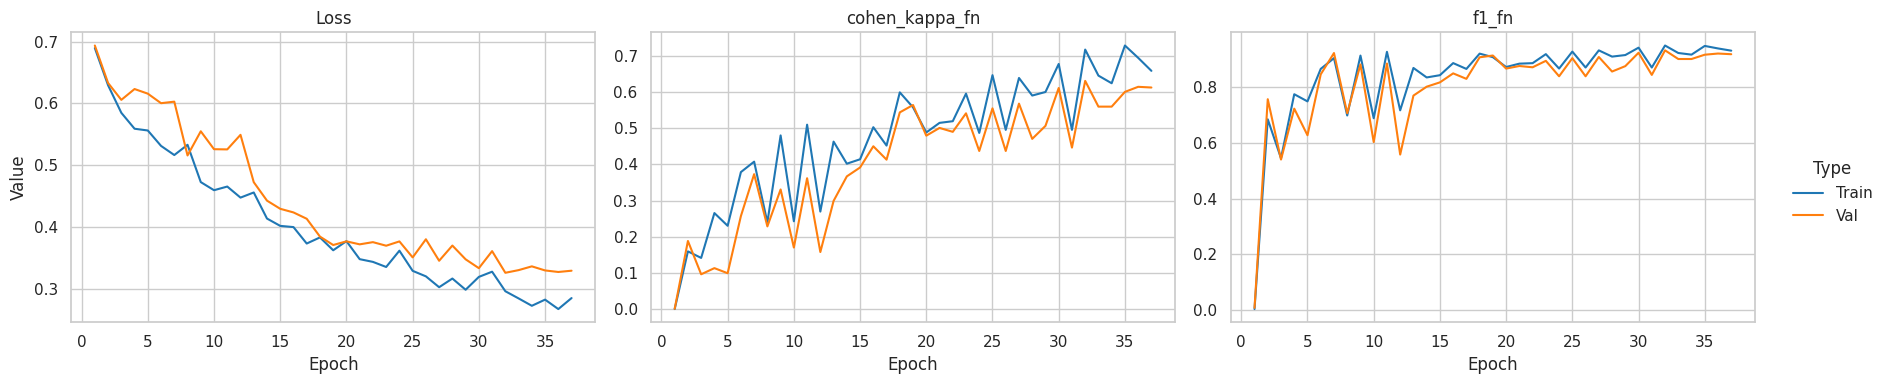

In [12]:
trainer_cnn_0.plot_epochs()

In [13]:
trainer_cnn_0.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.3739 | Test cohen_kappa_fn: 0.6064 | Test f1_fn: 0.9352


#### Visualization

In [14]:
visualizer_0 = Visualizer(model=trainer_cnn_0.model, device=device, labels_map=labels_map)

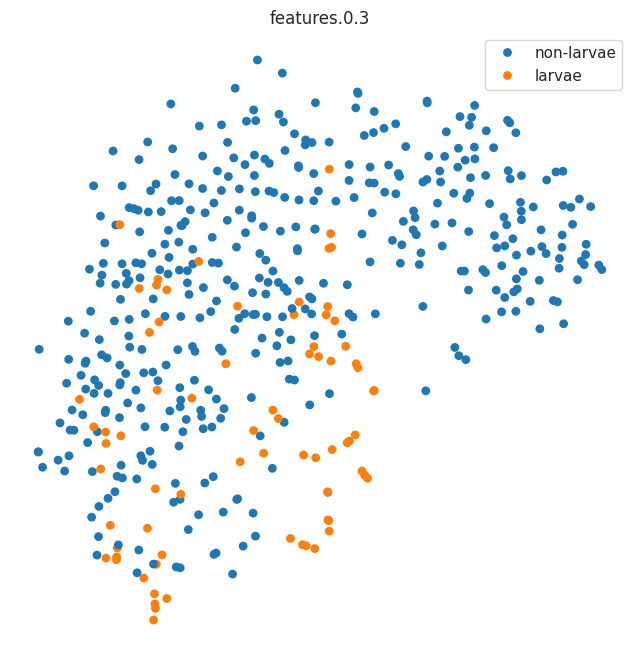

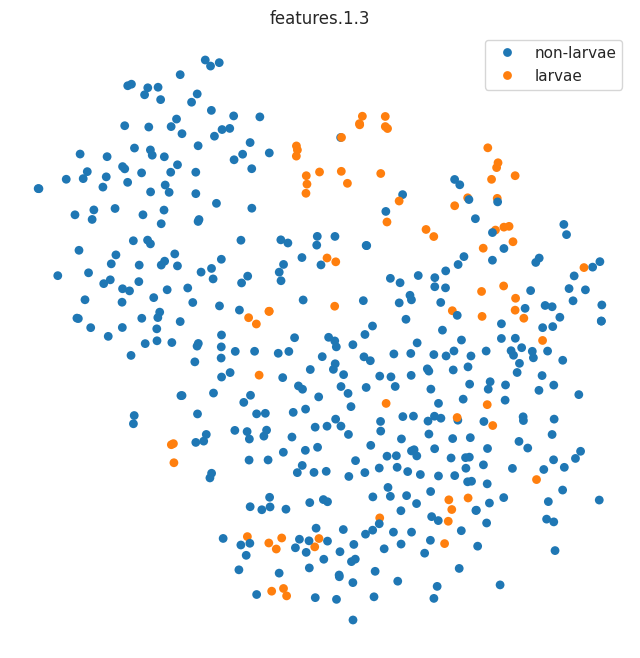

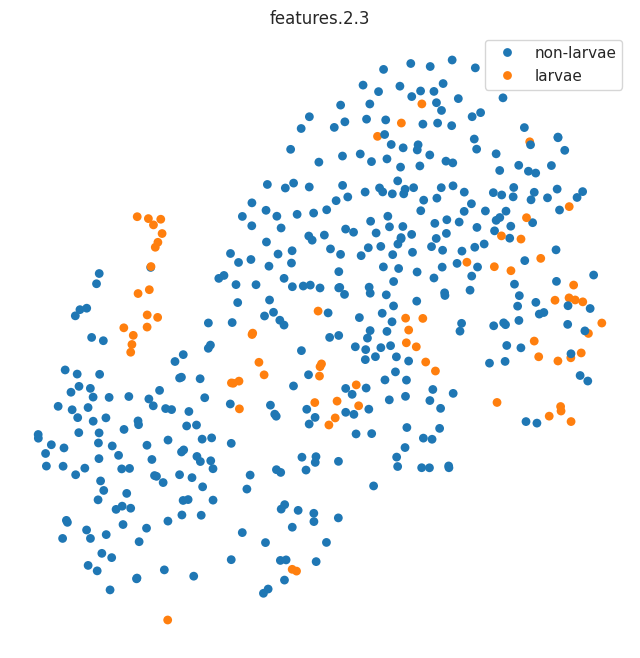

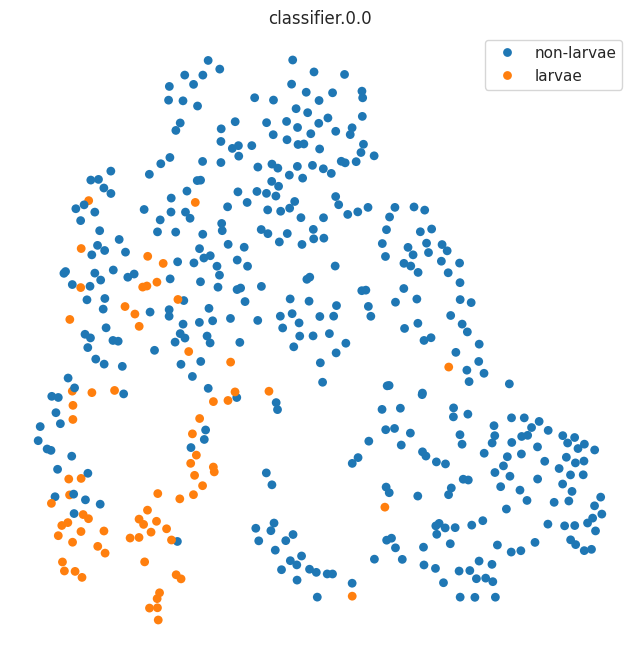

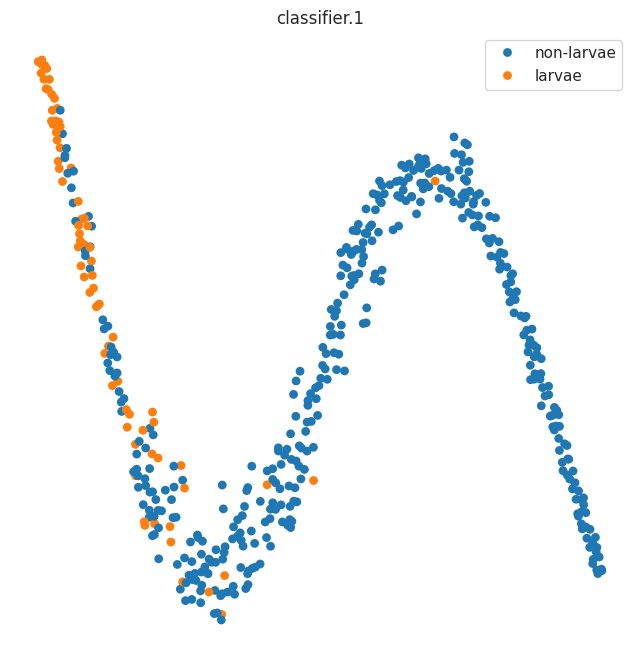

In [15]:
# Display layer representations
visualizer_0.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


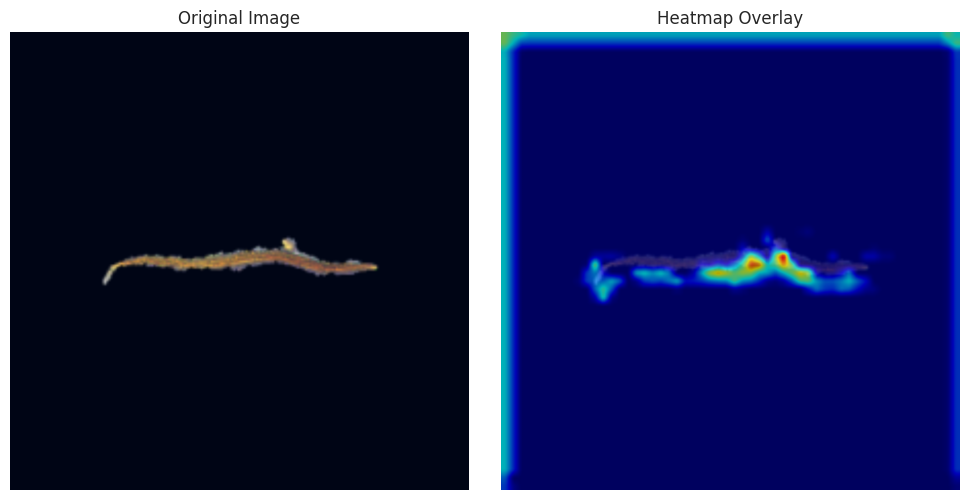

  Generating heatmap for Larvae...
  Predicted label is Non-larvae!


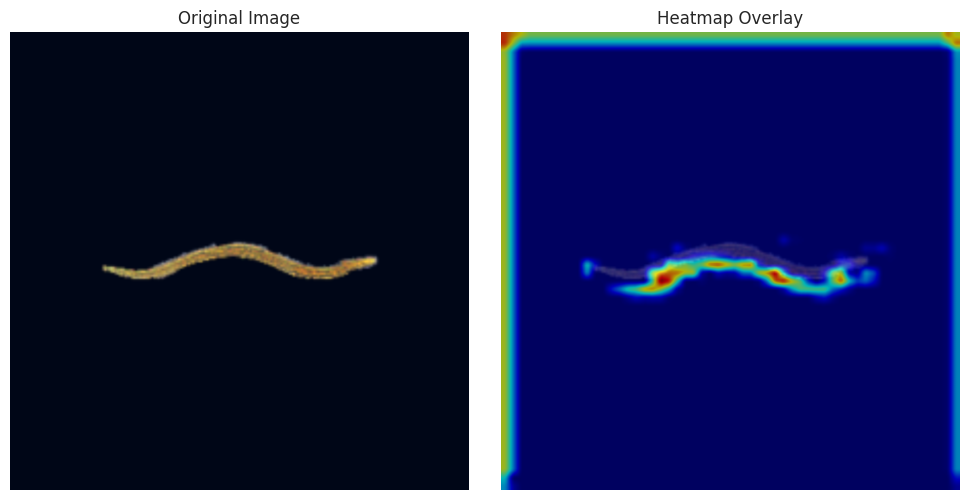

In [16]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_0.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_0.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.3. CNN1

In [17]:
cnn_1 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[64],
    conv_channels=[8,16,32,64],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_1, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 224, 224]             216
       BatchNorm2d-2          [-1, 8, 224, 224]              16
              ReLU-3          [-1, 8, 224, 224]               0
         MaxPool2d-4          [-1, 8, 112, 112]               0
            Conv2d-5         [-1, 16, 112, 112]           1,152
       BatchNorm2d-6         [-1, 16, 112, 112]              32
              ReLU-7         [-1, 16, 112, 112]               0
         MaxPool2d-8           [-1, 16, 56, 56]               0
            Conv2d-9           [-1, 32, 56, 56]           4,608
      BatchNorm2d-10           [-1, 32, 56, 56]              64
             ReLU-11           [-1, 32, 56, 56]               0
        MaxPool2d-12           [-1, 32, 28, 28]               0
           Conv2d-13           [-1, 64, 28, 28]          18,432
      BatchNorm2d-14           [-1, 64,

In [18]:
optimizer_cnn_1 = optim.Adam(cnn_1.parameters(), lr=2e-4)
scheduler_cnn_1 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_1, T_max=50, eta_min=1e-6)
ckpt_cnn_1 = "weights/larvae-cnn-1.pt"
trainer_cnn_1 = Trainer(
    model=cnn_1,
    optimizer=optimizer_cnn_1,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_1,
    checkpoint_path=ckpt_cnn_1,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [19]:
trainer_cnn_1.fit(train_loader, valid_loader, num_epochs=50)

📘 Epoch 1 | Train Loss: 0.6893 | Val Loss: 0.6858 | Train cohen_kappa_fn: 0.0037 | Val cohen_kappa_fn: 0.0119 | Train f1_fn: 0.0234 | Val f1_fn: 0.0714
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6578 | Val Loss: 0.6619 | Train cohen_kappa_fn: 0.2178 | Val cohen_kappa_fn: 0.1803 | Train f1_fn: 0.7802 | Val f1_fn: 0.8439
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.6191 | Val Loss: 0.6156 | Train cohen_kappa_fn: 0.1173 | Val cohen_kappa_fn: 0.1657 | Train f1_fn: 0.4956 | Val f1_fn: 0.5964
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.5650 | Val Loss: 0.5617 | Train cohen_kappa_fn: 0.2235 | Val cohen_kappa_fn: 0.2791 | Train f1_fn: 0.7184 | Val f1_fn: 0.7923
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.5333 | Val Loss: 0.5016 | Train cohen_kappa_fn: 0.2431 | Val cohen_kappa_fn: 0.3162 | Train f1_fn: 0.7342 | Val f1_fn: 0.7778
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.4904 | Val Loss: 0.4619 | Train cohen_kappa_fn: 0.2742 | Val cohen_kappa_fn: 0.3503 | Train f1_fn: 0.7587 | Val f1_fn: 0.8017
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.4501 | Val Loss: 0.4666 | Train cohen_kappa_fn: 0.1837 | Val cohen_kappa_fn: 0.2268 | Train f1_fn: 0.6250 | Val f1_fn: 0.6617
  ❄️ No improvement, model won't be saved!


📘 Epoch 8 | Train Loss: 0.4437 | Val Loss: 0.4020 | Train cohen_kappa_fn: 0.3798 | Val cohen_kappa_fn: 0.3664 | Train f1_fn: 0.8252 | Val f1_fn: 0.8121
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.4075 | Val Loss: 0.5069 | Train cohen_kappa_fn: 0.1789 | Val cohen_kappa_fn: 0.1659 | Train f1_fn: 0.6043 | Val f1_fn: 0.5600
  ❄️ No improvement, model won't be saved!


📘 Epoch 10 | Train Loss: 0.4203 | Val Loss: 0.3638 | Train cohen_kappa_fn: 0.4968 | Val cohen_kappa_fn: 0.4007 | Train f1_fn: 0.8759 | Val f1_fn: 0.8323
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.3944 | Val Loss: 0.3373 | Train cohen_kappa_fn: 0.5873 | Val cohen_kappa_fn: 0.5300 | Train f1_fn: 0.9182 | Val f1_fn: 0.9016
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.3925 | Val Loss: 0.3820 | Train cohen_kappa_fn: 0.3372 | Val cohen_kappa_fn: 0.3208 | Train f1_fn: 0.7698 | Val f1_fn: 0.7636
  ❄️ No improvement, model won't be saved!


📘 Epoch 13 | Train Loss: 0.3451 | Val Loss: 0.3176 | Train cohen_kappa_fn: 0.6138 | Val cohen_kappa_fn: 0.6017 | Train f1_fn: 0.9237 | Val f1_fn: 0.9201
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.3370 | Val Loss: 0.3109 | Train cohen_kappa_fn: 0.6045 | Val cohen_kappa_fn: 0.6211 | Train f1_fn: 0.9171 | Val f1_fn: 0.9240
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.3505 | Val Loss: 0.3057 | Train cohen_kappa_fn: 0.5707 | Val cohen_kappa_fn: 0.5458 | Train f1_fn: 0.9016 | Val f1_fn: 0.8925
  🔥 New best model saved!


📘 Epoch 16 | Train Loss: 0.2939 | Val Loss: 0.3023 | Train cohen_kappa_fn: 0.5418 | Val cohen_kappa_fn: 0.5517 | Train f1_fn: 0.8909 | Val f1_fn: 0.8947
  🔥 New best model saved!


📘 Epoch 17 | Train Loss: 0.2860 | Val Loss: 0.2810 | Train cohen_kappa_fn: 0.6812 | Val cohen_kappa_fn: 0.6899 | Train f1_fn: 0.9379 | Val f1_fn: 0.9425
  🔥 New best model saved!


📘 Epoch 18 | Train Loss: 0.2553 | Val Loss: 0.2964 | Train cohen_kappa_fn: 0.5620 | Val cohen_kappa_fn: 0.5172 | Train f1_fn: 0.8947 | Val f1_fn: 0.8811
  ❄️ No improvement, model won't be saved!


📘 Epoch 19 | Train Loss: 0.2758 | Val Loss: 0.2724 | Train cohen_kappa_fn: 0.6822 | Val cohen_kappa_fn: 0.6773 | Train f1_fn: 0.9398 | Val f1_fn: 0.9407
  🔥 New best model saved!


📘 Epoch 20 | Train Loss: 0.2488 | Val Loss: 0.2715 | Train cohen_kappa_fn: 0.7131 | Val cohen_kappa_fn: 0.6892 | Train f1_fn: 0.9451 | Val f1_fn: 0.9450
  🔥 New best model saved!


📘 Epoch 21 | Train Loss: 0.2686 | Val Loss: 0.2746 | Train cohen_kappa_fn: 0.6393 | Val cohen_kappa_fn: 0.6333 | Train f1_fn: 0.9221 | Val f1_fn: 0.9258
  ❄️ No improvement, model won't be saved!


📘 Epoch 22 | Train Loss: 0.2419 | Val Loss: 0.2644 | Train cohen_kappa_fn: 0.7401 | Val cohen_kappa_fn: 0.6855 | Train f1_fn: 0.9525 | Val f1_fn: 0.9427
  🔥 New best model saved!


📘 Epoch 23 | Train Loss: 0.2391 | Val Loss: 0.2665 | Train cohen_kappa_fn: 0.6895 | Val cohen_kappa_fn: 0.6554 | Train f1_fn: 0.9384 | Val f1_fn: 0.9320
  ❄️ No improvement, model won't be saved!


📘 Epoch 24 | Train Loss: 0.2418 | Val Loss: 0.2601 | Train cohen_kappa_fn: 0.7311 | Val cohen_kappa_fn: 0.6809 | Train f1_fn: 0.9491 | Val f1_fn: 0.9430
  🔥 New best model saved!


📘 Epoch 25 | Train Loss: 0.2189 | Val Loss: 0.2897 | Train cohen_kappa_fn: 0.7778 | Val cohen_kappa_fn: 0.7491 | Train f1_fn: 0.9651 | Val f1_fn: 0.9612
  ❄️ No improvement, model won't be saved!


📘 Epoch 26 | Train Loss: 0.2323 | Val Loss: 0.2588 | Train cohen_kappa_fn: 0.7366 | Val cohen_kappa_fn: 0.7063 | Train f1_fn: 0.9517 | Val f1_fn: 0.9490
  🔥 New best model saved!


📘 Epoch 27 | Train Loss: 0.2092 | Val Loss: 0.2530 | Train cohen_kappa_fn: 0.7366 | Val cohen_kappa_fn: 0.6693 | Train f1_fn: 0.9517 | Val f1_fn: 0.9387
  🔥 New best model saved!


📘 Epoch 28 | Train Loss: 0.2058 | Val Loss: 0.2612 | Train cohen_kappa_fn: 0.8017 | Val cohen_kappa_fn: 0.7239 | Train f1_fn: 0.9669 | Val f1_fn: 0.9529
  ❄️ No improvement, model won't be saved!


📘 Epoch 29 | Train Loss: 0.1921 | Val Loss: 0.2450 | Train cohen_kappa_fn: 0.7611 | Val cohen_kappa_fn: 0.7106 | Train f1_fn: 0.9573 | Val f1_fn: 0.9488
  🔥 New best model saved!


📘 Epoch 30 | Train Loss: 0.2006 | Val Loss: 0.2481 | Train cohen_kappa_fn: 0.7964 | Val cohen_kappa_fn: 0.6977 | Train f1_fn: 0.9634 | Val f1_fn: 0.9470
  ❄️ No improvement, model won't be saved!


📘 Epoch 31 | Train Loss: 0.2135 | Val Loss: 0.2398 | Train cohen_kappa_fn: 0.7617 | Val cohen_kappa_fn: 0.6937 | Train f1_fn: 0.9563 | Val f1_fn: 0.9448
  🔥 New best model saved!


📘 Epoch 32 | Train Loss: 0.1964 | Val Loss: 0.2477 | Train cohen_kappa_fn: 0.7990 | Val cohen_kappa_fn: 0.7197 | Train f1_fn: 0.9652 | Val f1_fn: 0.9531
  ❄️ No improvement, model won't be saved!


📘 Epoch 33 | Train Loss: 0.1969 | Val Loss: 0.2385 | Train cohen_kappa_fn: 0.7723 | Val cohen_kappa_fn: 0.7021 | Train f1_fn: 0.9587 | Val f1_fn: 0.9468
  🔥 New best model saved!


📘 Epoch 34 | Train Loss: 0.1944 | Val Loss: 0.2489 | Train cohen_kappa_fn: 0.7802 | Val cohen_kappa_fn: 0.7239 | Train f1_fn: 0.9622 | Val f1_fn: 0.9529
  ❄️ No improvement, model won't be saved!


📘 Epoch 35 | Train Loss: 0.1909 | Val Loss: 0.2421 | Train cohen_kappa_fn: 0.7817 | Val cohen_kappa_fn: 0.7106 | Train f1_fn: 0.9612 | Val f1_fn: 0.9488
  ❄️ No improvement, model won't be saved!


📘 Epoch 36 | Train Loss: 0.1870 | Val Loss: 0.2554 | Train cohen_kappa_fn: 0.7865 | Val cohen_kappa_fn: 0.7330 | Train f1_fn: 0.9629 | Val f1_fn: 0.9549
  ❄️ No improvement, model won't be saved!


📘 Epoch 37 | Train Loss: 0.2064 | Val Loss: 0.2576 | Train cohen_kappa_fn: 0.8127 | Val cohen_kappa_fn: 0.7151 | Train f1_fn: 0.9674 | Val f1_fn: 0.9509
  ❄️ No improvement, model won't be saved!


📘 Epoch 38 | Train Loss: 0.2003 | Val Loss: 0.2371 | Train cohen_kappa_fn: 0.7781 | Val cohen_kappa_fn: 0.7021 | Train f1_fn: 0.9604 | Val f1_fn: 0.9468
  🔥 New best model saved!


📘 Epoch 39 | Train Loss: 0.1886 | Val Loss: 0.2304 | Train cohen_kappa_fn: 0.7293 | Val cohen_kappa_fn: 0.6693 | Train f1_fn: 0.9482 | Val f1_fn: 0.9387
  🔥 New best model saved!


📘 Epoch 40 | Train Loss: 0.1865 | Val Loss: 0.2363 | Train cohen_kappa_fn: 0.7709 | Val cohen_kappa_fn: 0.6977 | Train f1_fn: 0.9588 | Val f1_fn: 0.9470
  ❄️ No improvement, model won't be saved!


📘 Epoch 41 | Train Loss: 0.1759 | Val Loss: 0.2322 | Train cohen_kappa_fn: 0.7771 | Val cohen_kappa_fn: 0.6855 | Train f1_fn: 0.9594 | Val f1_fn: 0.9427
  ❄️ No improvement, model won't be saved!


📘 Epoch 42 | Train Loss: 0.1732 | Val Loss: 0.2366 | Train cohen_kappa_fn: 0.7856 | Val cohen_kappa_fn: 0.6977 | Train f1_fn: 0.9610 | Val f1_fn: 0.9470
  ❄️ No improvement, model won't be saved!


📘 Epoch 43 | Train Loss: 0.1744 | Val Loss: 0.2357 | Train cohen_kappa_fn: 0.7625 | Val cohen_kappa_fn: 0.6977 | Train f1_fn: 0.9573 | Val f1_fn: 0.9470
  ❄️ No improvement, model won't be saved!


📘 Epoch 44 | Train Loss: 0.1769 | Val Loss: 0.2380 | Train cohen_kappa_fn: 0.8039 | Val cohen_kappa_fn: 0.6977 | Train f1_fn: 0.9659 | Val f1_fn: 0.9470
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


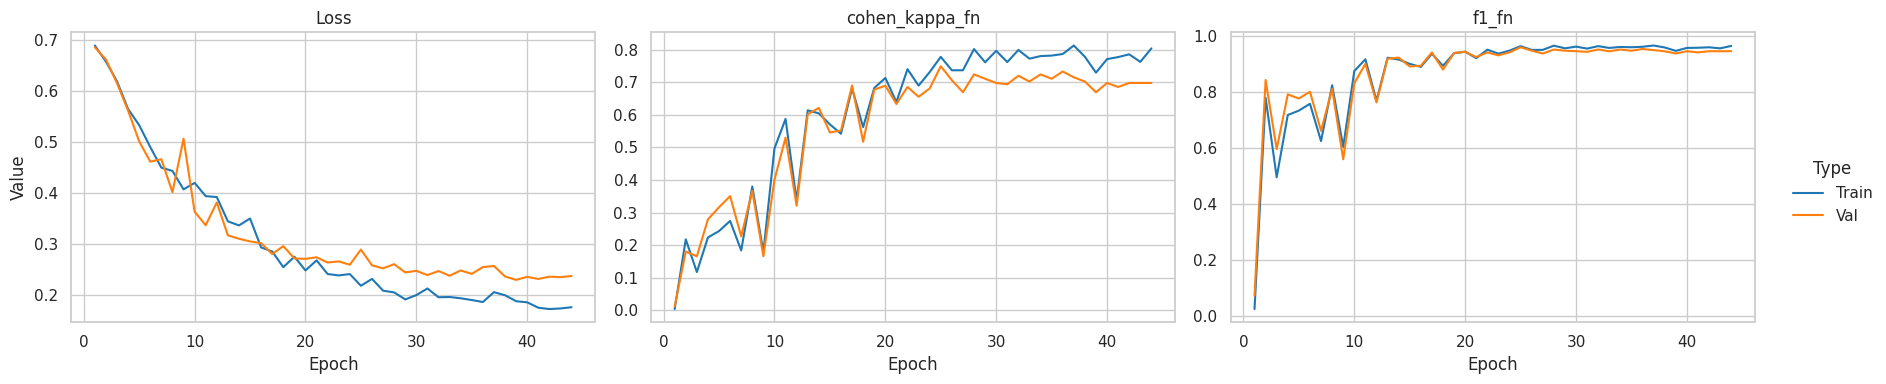

In [20]:
trainer_cnn_1.plot_epochs()

In [21]:
trainer_cnn_1.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.2395 | Test cohen_kappa_fn: 0.7123 | Test f1_fn: 0.9495


#### Visualization

In [22]:
visualizer_1 = Visualizer(model=trainer_cnn_1.model, device=device, labels_map=labels_map)

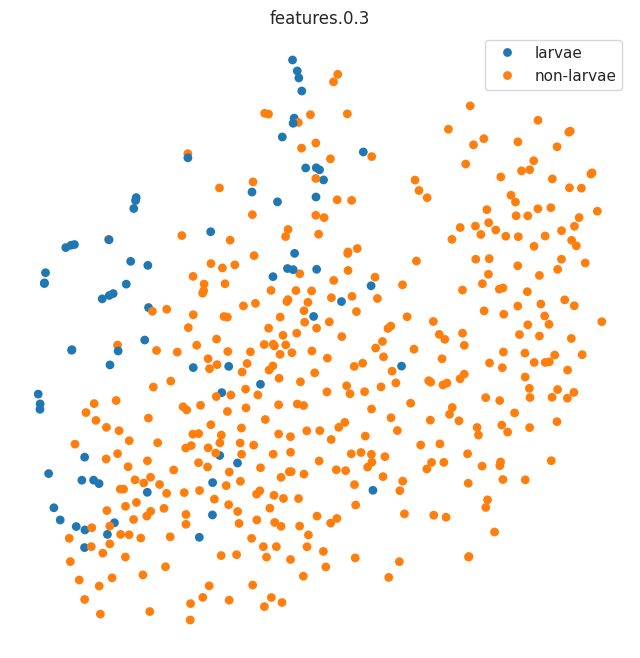

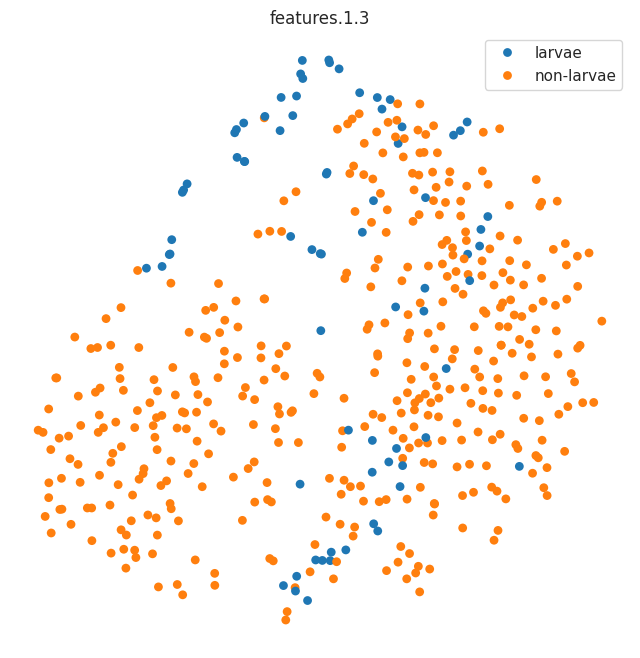

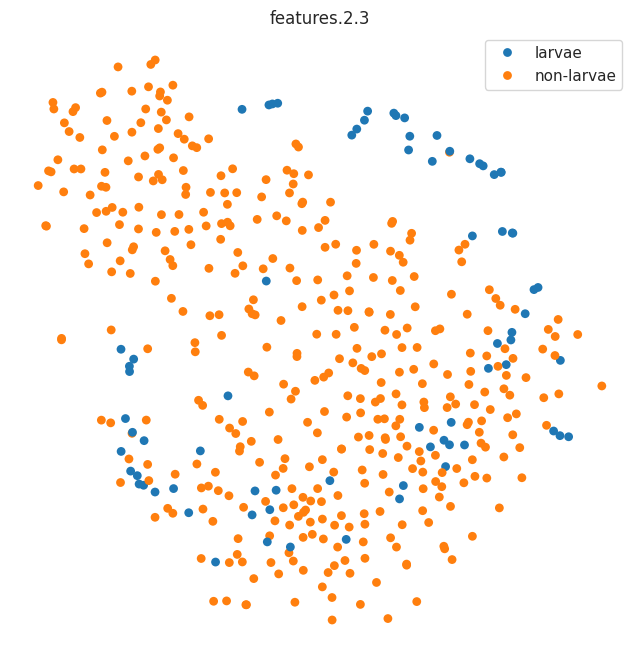

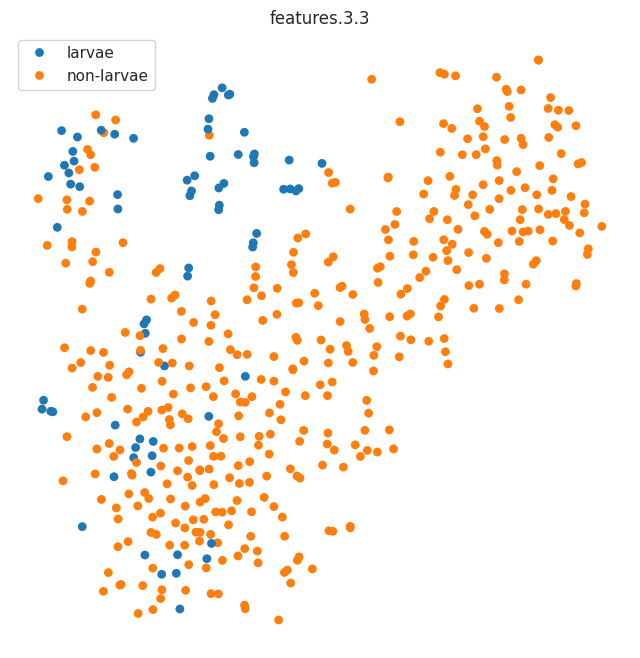

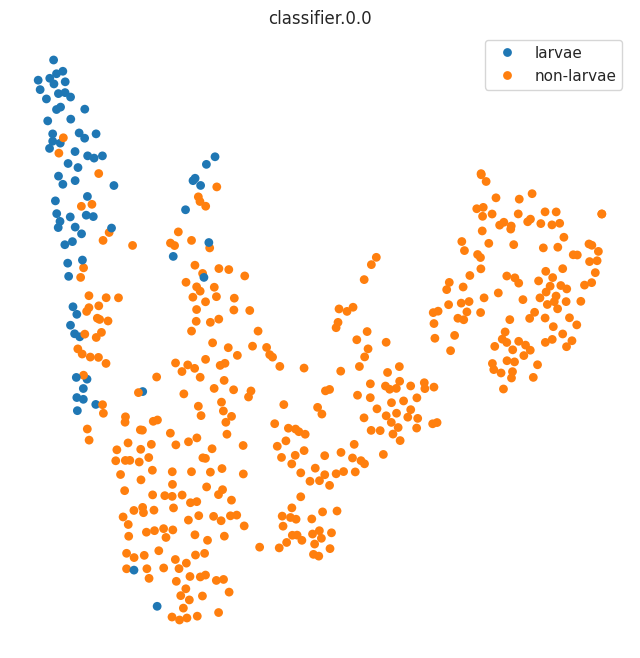

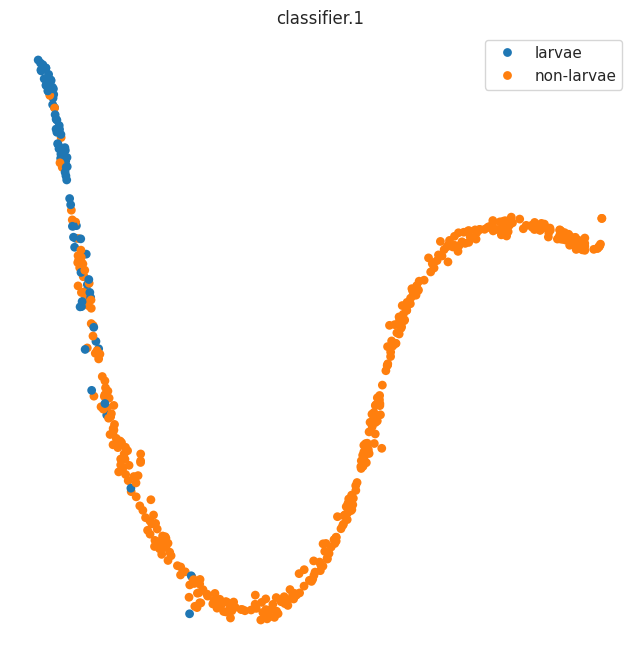

In [23]:
# Display layer representations
visualizer_1.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


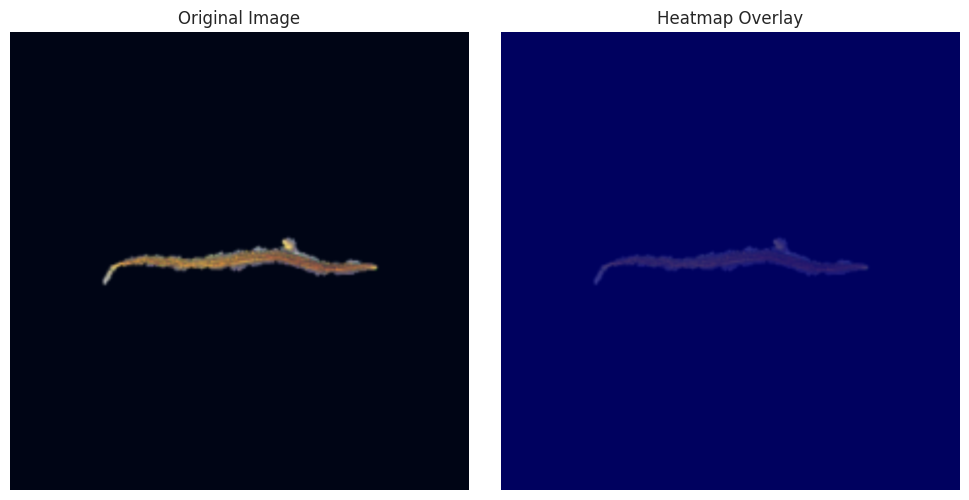

  Generating heatmap for Larvae...
  Predicted label is Larvae!


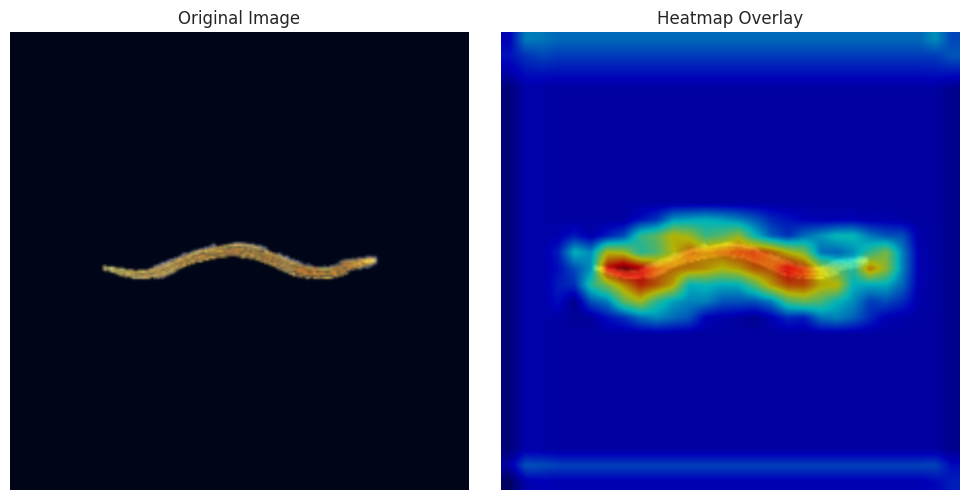

In [24]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_1.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_1.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.4. CNN2

In [25]:
cnn_2 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[128],
    conv_channels=[8,16,32,64],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_2, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 224, 224]             216
       BatchNorm2d-2          [-1, 8, 224, 224]              16
              ReLU-3          [-1, 8, 224, 224]               0
         MaxPool2d-4          [-1, 8, 112, 112]               0
            Conv2d-5         [-1, 16, 112, 112]           1,152
       BatchNorm2d-6         [-1, 16, 112, 112]              32
              ReLU-7         [-1, 16, 112, 112]               0
         MaxPool2d-8           [-1, 16, 56, 56]               0
            Conv2d-9           [-1, 32, 56, 56]           4,608
      BatchNorm2d-10           [-1, 32, 56, 56]              64
             ReLU-11           [-1, 32, 56, 56]               0
        MaxPool2d-12           [-1, 32, 28, 28]               0
           Conv2d-13           [-1, 64, 28, 28]          18,432
      BatchNorm2d-14           [-1, 64,

In [26]:
optimizer_cnn_2 = optim.Adam(cnn_2.parameters(), lr=2e-4)
scheduler_cnn_2 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_2, T_max=50, eta_min=1e-6)
ckpt_cnn_2 = "weights/larvae-cnn-2.pt"
trainer_cnn_2 = Trainer(
    model=cnn_2,
    optimizer=optimizer_cnn_2,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_2,
    checkpoint_path=ckpt_cnn_2,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [27]:
trainer_cnn_2.fit(train_loader, valid_loader, num_epochs=50)

📘 Epoch 1 | Train Loss: 0.6857 | Val Loss: 0.6830 | Train cohen_kappa_fn: 0.0098 | Val cohen_kappa_fn: 0.0501 | Train f1_fn: 0.0603 | Val f1_fn: 0.2524
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6416 | Val Loss: 0.6549 | Train cohen_kappa_fn: 0.1605 | Val cohen_kappa_fn: 0.1933 | Train f1_fn: 0.6445 | Val f1_fn: 0.7692
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.5927 | Val Loss: 0.6211 | Train cohen_kappa_fn: 0.1490 | Val cohen_kappa_fn: 0.2353 | Train f1_fn: 0.5899 | Val f1_fn: 0.7732
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.5684 | Val Loss: 0.5883 | Train cohen_kappa_fn: 0.2061 | Val cohen_kappa_fn: 0.2810 | Train f1_fn: 0.6931 | Val f1_fn: 0.8532
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.5381 | Val Loss: 0.6614 | Train cohen_kappa_fn: 0.3698 | Val cohen_kappa_fn: 0.1950 | Train f1_fn: 0.8862 | Val f1_fn: 0.9167
  ❄️ No improvement, model won't be saved!


📘 Epoch 6 | Train Loss: 0.5162 | Val Loss: 0.5260 | Train cohen_kappa_fn: 0.2654 | Val cohen_kappa_fn: 0.2870 | Train f1_fn: 0.7371 | Val f1_fn: 0.8034
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.4966 | Val Loss: 0.4921 | Train cohen_kappa_fn: 0.2850 | Val cohen_kappa_fn: 0.3400 | Train f1_fn: 0.7623 | Val f1_fn: 0.8299
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.4593 | Val Loss: 0.6280 | Train cohen_kappa_fn: 0.4749 | Val cohen_kappa_fn: 0.4002 | Train f1_fn: 0.9325 | Val f1_fn: 0.9354
  ❄️ No improvement, model won't be saved!


📘 Epoch 9 | Train Loss: 0.4536 | Val Loss: 0.4148 | Train cohen_kappa_fn: 0.2614 | Val cohen_kappa_fn: 0.3278 | Train f1_fn: 0.7061 | Val f1_fn: 0.7692
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.4108 | Val Loss: 0.4833 | Train cohen_kappa_fn: 0.6483 | Val cohen_kappa_fn: 0.6156 | Train f1_fn: 0.9478 | Val f1_fn: 0.9476
  ❄️ No improvement, model won't be saved!


📘 Epoch 11 | Train Loss: 0.3956 | Val Loss: 0.3861 | Train cohen_kappa_fn: 0.4324 | Val cohen_kappa_fn: 0.3650 | Train f1_fn: 0.8396 | Val f1_fn: 0.7965
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.3742 | Val Loss: 0.3591 | Train cohen_kappa_fn: 0.6010 | Val cohen_kappa_fn: 0.6535 | Train f1_fn: 0.9184 | Val f1_fn: 0.9346
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.3554 | Val Loss: 0.3354 | Train cohen_kappa_fn: 0.6326 | Val cohen_kappa_fn: 0.6307 | Train f1_fn: 0.9256 | Val f1_fn: 0.9284
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.3620 | Val Loss: 0.3326 | Train cohen_kappa_fn: 0.4884 | Val cohen_kappa_fn: 0.5228 | Train f1_fn: 0.8711 | Val f1_fn: 0.8834
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.3288 | Val Loss: 0.3046 | Train cohen_kappa_fn: 0.7604 | Val cohen_kappa_fn: 0.6973 | Train f1_fn: 0.9583 | Val f1_fn: 0.9493
  🔥 New best model saved!


📘 Epoch 16 | Train Loss: 0.2898 | Val Loss: 0.3118 | Train cohen_kappa_fn: 0.5280 | Val cohen_kappa_fn: 0.4961 | Train f1_fn: 0.8854 | Val f1_fn: 0.8661
  ❄️ No improvement, model won't be saved!


📘 Epoch 17 | Train Loss: 0.2689 | Val Loss: 0.2963 | Train cohen_kappa_fn: 0.7484 | Val cohen_kappa_fn: 0.7449 | Train f1_fn: 0.9615 | Val f1_fn: 0.9613
  🔥 New best model saved!


📘 Epoch 18 | Train Loss: 0.3094 | Val Loss: 0.3751 | Train cohen_kappa_fn: 0.3759 | Val cohen_kappa_fn: 0.3469 | Train f1_fn: 0.7982 | Val f1_fn: 0.7727
  ❄️ No improvement, model won't be saved!


📘 Epoch 19 | Train Loss: 0.3073 | Val Loss: 0.2933 | Train cohen_kappa_fn: 0.7764 | Val cohen_kappa_fn: 0.8082 | Train f1_fn: 0.9651 | Val f1_fn: 0.9727
  🔥 New best model saved!


📘 Epoch 20 | Train Loss: 0.2363 | Val Loss: 0.2451 | Train cohen_kappa_fn: 0.7317 | Val cohen_kappa_fn: 0.7867 | Train f1_fn: 0.9510 | Val f1_fn: 0.9667
  🔥 New best model saved!


📘 Epoch 21 | Train Loss: 0.2181 | Val Loss: 0.2576 | Train cohen_kappa_fn: 0.7889 | Val cohen_kappa_fn: 0.8006 | Train f1_fn: 0.9646 | Val f1_fn: 0.9707
  ❄️ No improvement, model won't be saved!


📘 Epoch 22 | Train Loss: 0.2446 | Val Loss: 0.2250 | Train cohen_kappa_fn: 0.7115 | Val cohen_kappa_fn: 0.7281 | Train f1_fn: 0.9442 | Val f1_fn: 0.9527
  🔥 New best model saved!


📘 Epoch 23 | Train Loss: 0.2054 | Val Loss: 0.2241 | Train cohen_kappa_fn: 0.7314 | Val cohen_kappa_fn: 0.7193 | Train f1_fn: 0.9500 | Val f1_fn: 0.9508
  🔥 New best model saved!


📘 Epoch 24 | Train Loss: 0.2069 | Val Loss: 0.2160 | Train cohen_kappa_fn: 0.7209 | Val cohen_kappa_fn: 0.6629 | Train f1_fn: 0.9447 | Val f1_fn: 0.9341
  🔥 New best model saved!


📘 Epoch 25 | Train Loss: 0.1899 | Val Loss: 0.2343 | Train cohen_kappa_fn: 0.7927 | Val cohen_kappa_fn: 0.7935 | Train f1_fn: 0.9654 | Val f1_fn: 0.9687
  ❄️ No improvement, model won't be saved!


📘 Epoch 26 | Train Loss: 0.2143 | Val Loss: 0.2100 | Train cohen_kappa_fn: 0.6648 | Val cohen_kappa_fn: 0.6706 | Train f1_fn: 0.9298 | Val f1_fn: 0.9362
  🔥 New best model saved!


📘 Epoch 27 | Train Loss: 0.2003 | Val Loss: 0.2136 | Train cohen_kappa_fn: 0.7603 | Val cohen_kappa_fn: 0.7460 | Train f1_fn: 0.9564 | Val f1_fn: 0.9567
  ❄️ No improvement, model won't be saved!


📘 Epoch 28 | Train Loss: 0.1990 | Val Loss: 0.2180 | Train cohen_kappa_fn: 0.7582 | Val cohen_kappa_fn: 0.7330 | Train f1_fn: 0.9574 | Val f1_fn: 0.9549
  ❄️ No improvement, model won't be saved!


📘 Epoch 29 | Train Loss: 0.1788 | Val Loss: 0.2160 | Train cohen_kappa_fn: 0.7329 | Val cohen_kappa_fn: 0.6937 | Train f1_fn: 0.9500 | Val f1_fn: 0.9448
  ❄️ No improvement, model won't be saved!


📘 Epoch 30 | Train Loss: 0.2008 | Val Loss: 0.2153 | Train cohen_kappa_fn: 0.7440 | Val cohen_kappa_fn: 0.6706 | Train f1_fn: 0.9514 | Val f1_fn: 0.9362
  ❄️ No improvement, model won't be saved!


📘 Epoch 31 | Train Loss: 0.1711 | Val Loss: 0.2340 | Train cohen_kappa_fn: 0.8186 | Val cohen_kappa_fn: 0.7935 | Train f1_fn: 0.9700 | Val f1_fn: 0.9687
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


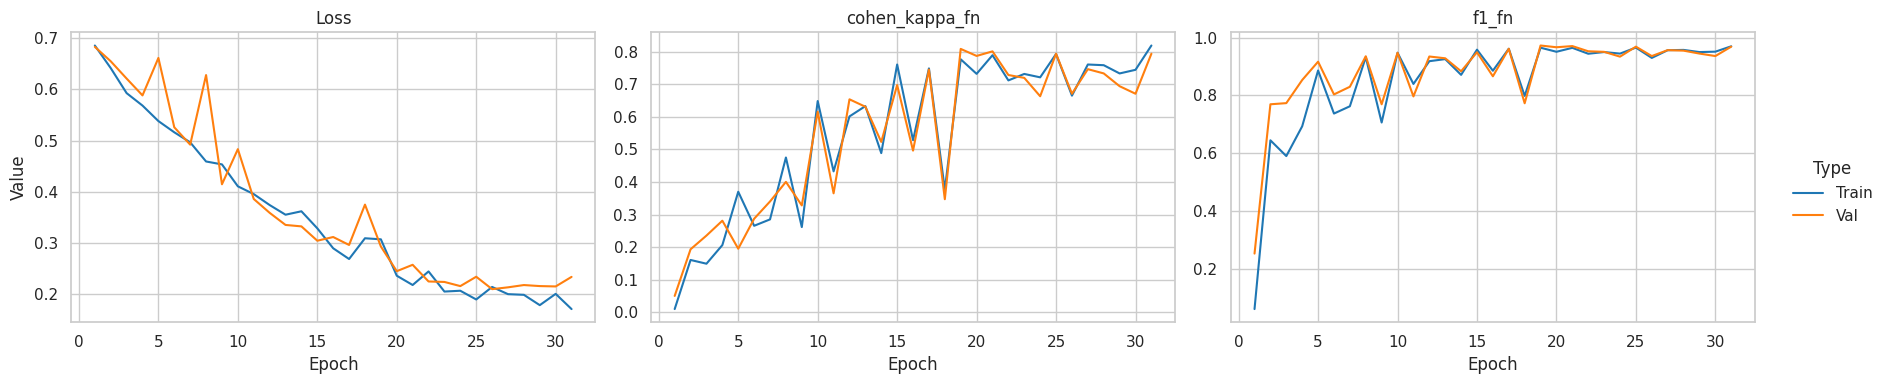

In [28]:
trainer_cnn_2.plot_epochs()

In [29]:
trainer_cnn_2.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.2243 | Test cohen_kappa_fn: 0.7233 | Test f1_fn: 0.9490


#### Visualization

In [30]:
visualizer_2 = Visualizer(model=trainer_cnn_2.model, device=device, labels_map=labels_map)

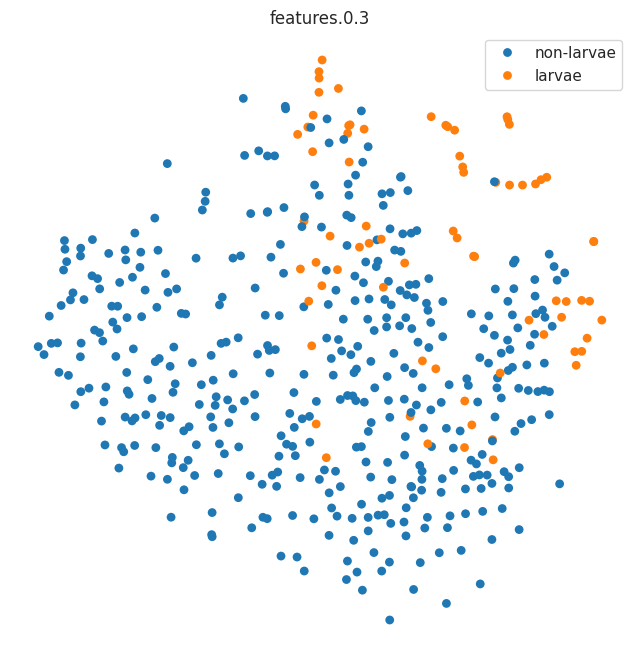

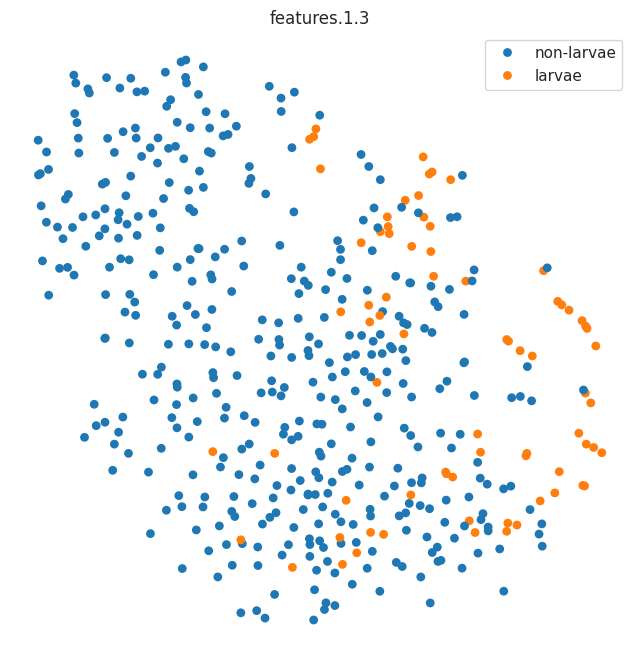

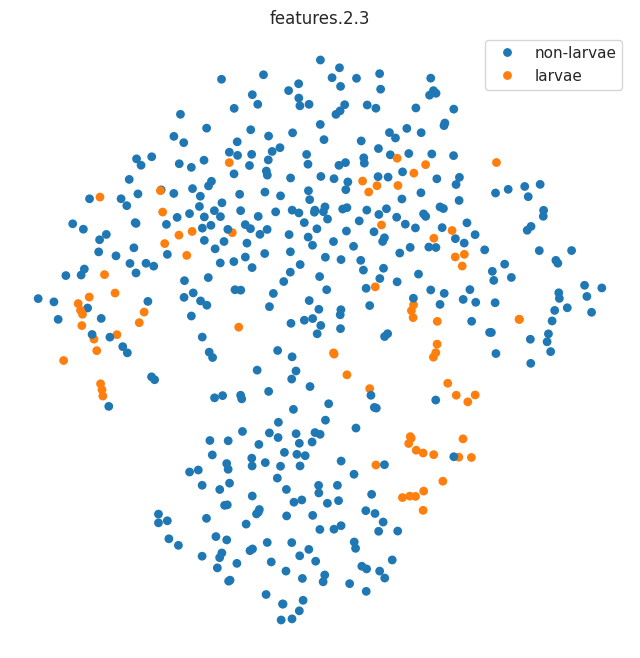

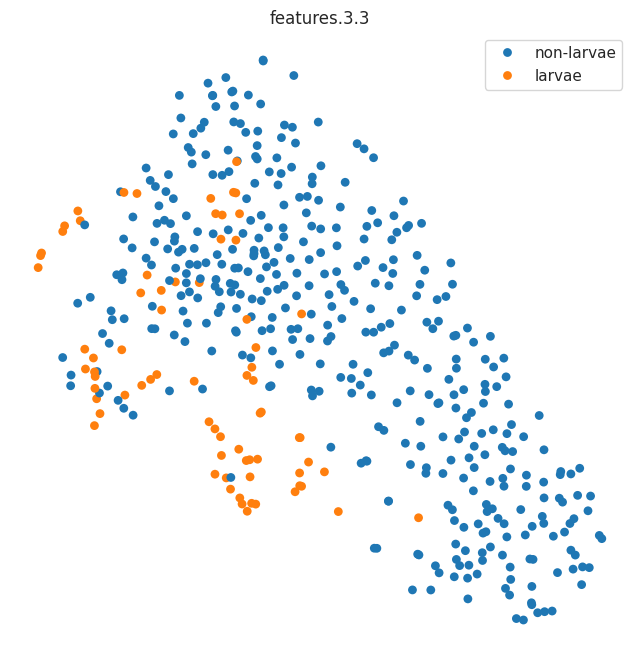

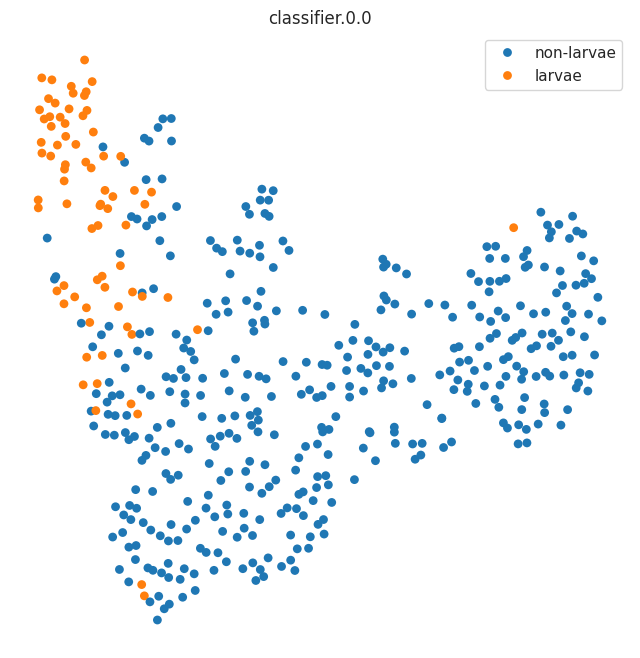

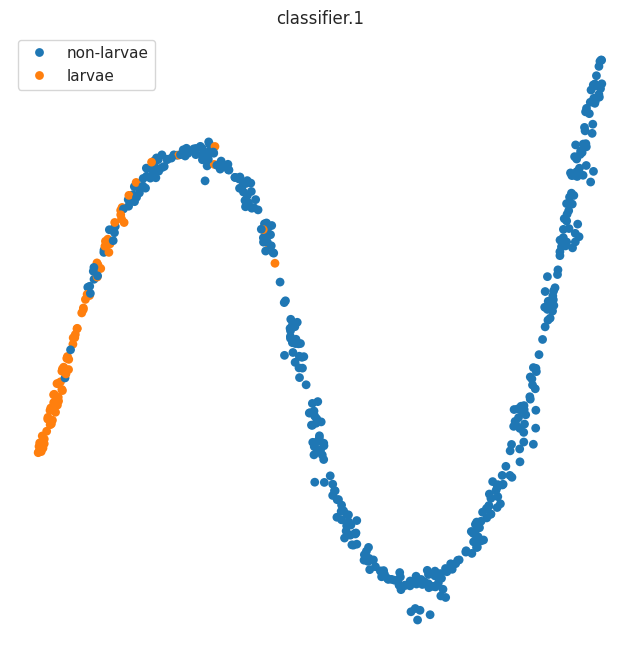

In [31]:
# Display layer representations
visualizer_2.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


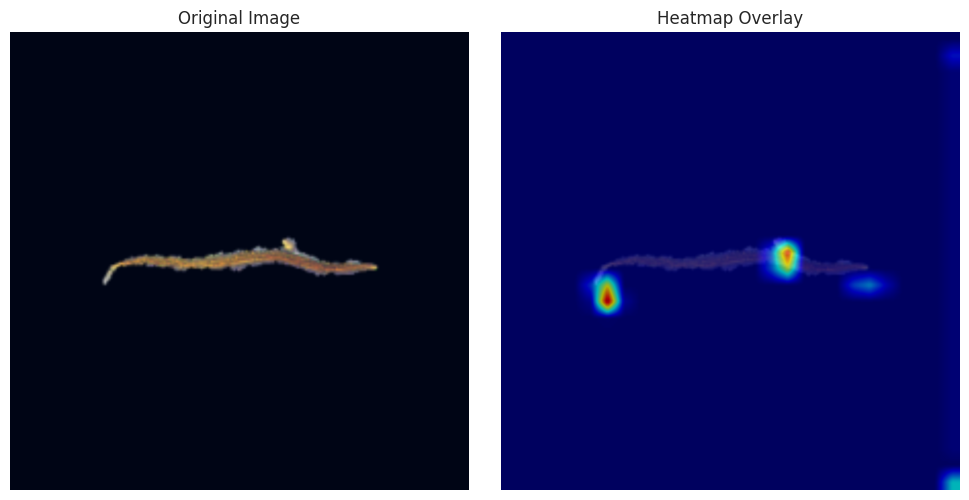

  Generating heatmap for Larvae...
  Predicted label is Larvae!


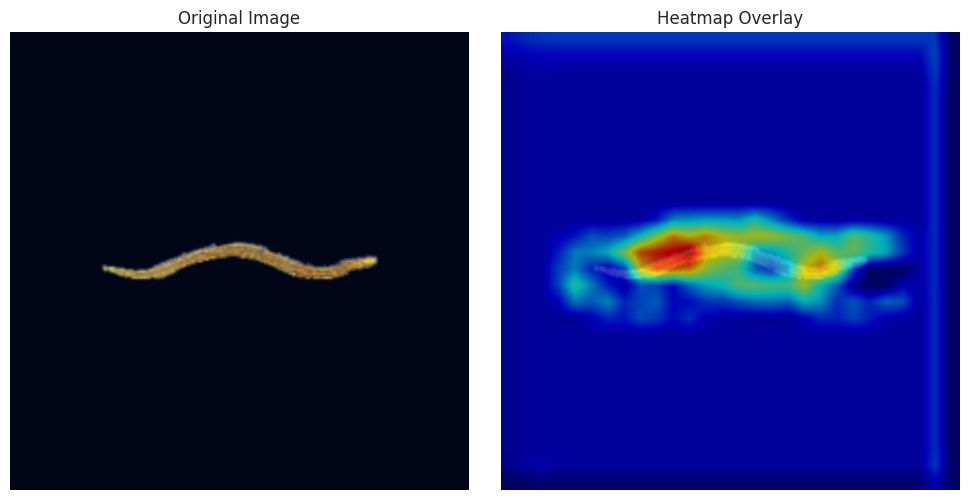

In [32]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_2.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_2.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.5. CNN3

In [33]:
cnn_3 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[128],
    conv_channels=[8,16,32,128],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_3, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 224, 224]             216
       BatchNorm2d-2          [-1, 8, 224, 224]              16
              ReLU-3          [-1, 8, 224, 224]               0
         MaxPool2d-4          [-1, 8, 112, 112]               0
            Conv2d-5         [-1, 16, 112, 112]           1,152
       BatchNorm2d-6         [-1, 16, 112, 112]              32
              ReLU-7         [-1, 16, 112, 112]               0
         MaxPool2d-8           [-1, 16, 56, 56]               0
            Conv2d-9           [-1, 32, 56, 56]           4,608
      BatchNorm2d-10           [-1, 32, 56, 56]              64
             ReLU-11           [-1, 32, 56, 56]               0
        MaxPool2d-12           [-1, 32, 28, 28]               0
           Conv2d-13          [-1, 128, 28, 28]          36,864
      BatchNorm2d-14          [-1, 128,

In [34]:
optimizer_cnn_3 = optim.Adam(cnn_3.parameters(), lr=2e-4)
scheduler_cnn_3 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_3, T_max=50, eta_min=1e-6)
ckpt_cnn_3 = "weights/larvae-cnn-3.pt"
trainer_cnn_3 = Trainer(
    model=cnn_3,
    optimizer=optimizer_cnn_3,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_3,
    checkpoint_path=ckpt_cnn_3,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [35]:
trainer_cnn_3.fit(train_loader, valid_loader, num_epochs=50)

❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 1 | Train Loss: 0.9115 | Val Loss: 0.6952 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.7005 | Val Loss: 0.6857 | Train cohen_kappa_fn: 0.0978 | Val cohen_kappa_fn: 0.0900 | Train f1_fn: 0.8732 | Val f1_fn: 0.9181
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.6666 | Val Loss: 0.6710 | Train cohen_kappa_fn: 0.1203 | Val cohen_kappa_fn: 0.0762 | Train f1_fn: 0.5556 | Val f1_fn: 0.6697
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.6325 | Val Loss: 0.6580 | Train cohen_kappa_fn: 0.2450 | Val cohen_kappa_fn: 0.0992 | Train f1_fn: 0.8020 | Val f1_fn: 0.8877
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.6101 | Val Loss: 0.6127 | Train cohen_kappa_fn: 0.1594 | Val cohen_kappa_fn: 0.2374 | Train f1_fn: 0.5774 | Val f1_fn: 0.7881
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.5689 | Val Loss: 0.6631 | Train cohen_kappa_fn: 0.3641 | Val cohen_kappa_fn: 0.1835 | Train f1_fn: 0.8931 | Val f1_fn: 0.9188
  ❄️ No improvement, model won't be saved!


📘 Epoch 7 | Train Loss: 0.5455 | Val Loss: 0.5789 | Train cohen_kappa_fn: 0.2433 | Val cohen_kappa_fn: 0.2567 | Train f1_fn: 0.7159 | Val f1_fn: 0.8521
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.5093 | Val Loss: 0.5370 | Train cohen_kappa_fn: 0.3131 | Val cohen_kappa_fn: 0.2879 | Train f1_fn: 0.7816 | Val f1_fn: 0.8797
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.4758 | Val Loss: 0.5046 | Train cohen_kappa_fn: 0.4028 | Val cohen_kappa_fn: 0.3509 | Train f1_fn: 0.8381 | Val f1_fn: 0.8935
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.4387 | Val Loss: 0.4776 | Train cohen_kappa_fn: 0.4141 | Val cohen_kappa_fn: 0.3970 | Train f1_fn: 0.8393 | Val f1_fn: 0.8842
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.4063 | Val Loss: 0.4170 | Train cohen_kappa_fn: 0.4239 | Val cohen_kappa_fn: 0.4514 | Train f1_fn: 0.8333 | Val f1_fn: 0.8782
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.3731 | Val Loss: 0.4623 | Train cohen_kappa_fn: 0.6591 | Val cohen_kappa_fn: 0.5360 | Train f1_fn: 0.9409 | Val f1_fn: 0.9367
  ❄️ No improvement, model won't be saved!


📘 Epoch 13 | Train Loss: 0.3819 | Val Loss: 0.3932 | Train cohen_kappa_fn: 0.2663 | Val cohen_kappa_fn: 0.3768 | Train f1_fn: 0.7019 | Val f1_fn: 0.8044
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.3482 | Val Loss: 0.5193 | Train cohen_kappa_fn: 0.7155 | Val cohen_kappa_fn: 0.5278 | Train f1_fn: 0.9563 | Val f1_fn: 0.9391
  ❄️ No improvement, model won't be saved!


📘 Epoch 15 | Train Loss: 0.3364 | Val Loss: 0.3631 | Train cohen_kappa_fn: 0.4127 | Val cohen_kappa_fn: 0.4547 | Train f1_fn: 0.8286 | Val f1_fn: 0.8699
  🔥 New best model saved!


📘 Epoch 16 | Train Loss: 0.3295 | Val Loss: 0.4057 | Train cohen_kappa_fn: 0.6138 | Val cohen_kappa_fn: 0.5559 | Train f1_fn: 0.9237 | Val f1_fn: 0.9271
  ❄️ No improvement, model won't be saved!


📘 Epoch 17 | Train Loss: 0.3119 | Val Loss: 0.3587 | Train cohen_kappa_fn: 0.5705 | Val cohen_kappa_fn: 0.5387 | Train f1_fn: 0.9069 | Val f1_fn: 0.9160
  🔥 New best model saved!


📘 Epoch 18 | Train Loss: 0.2902 | Val Loss: 0.3337 | Train cohen_kappa_fn: 0.6440 | Val cohen_kappa_fn: 0.5940 | Train f1_fn: 0.9249 | Val f1_fn: 0.9254
  🔥 New best model saved!


📘 Epoch 19 | Train Loss: 0.2648 | Val Loss: 0.3199 | Train cohen_kappa_fn: 0.6518 | Val cohen_kappa_fn: 0.6748 | Train f1_fn: 0.9285 | Val f1_fn: 0.9456
  🔥 New best model saved!


📘 Epoch 20 | Train Loss: 0.2624 | Val Loss: 0.3314 | Train cohen_kappa_fn: 0.6665 | Val cohen_kappa_fn: 0.6815 | Train f1_fn: 0.9357 | Val f1_fn: 0.9522
  ❄️ No improvement, model won't be saved!


📘 Epoch 21 | Train Loss: 0.2665 | Val Loss: 0.3270 | Train cohen_kappa_fn: 0.6515 | Val cohen_kappa_fn: 0.6524 | Train f1_fn: 0.9265 | Val f1_fn: 0.9418
  ❄️ No improvement, model won't be saved!


📘 Epoch 22 | Train Loss: 0.2432 | Val Loss: 0.3160 | Train cohen_kappa_fn: 0.6422 | Val cohen_kappa_fn: 0.6836 | Train f1_fn: 0.9250 | Val f1_fn: 0.9476
  🔥 New best model saved!


📘 Epoch 23 | Train Loss: 0.2374 | Val Loss: 0.3443 | Train cohen_kappa_fn: 0.6970 | Val cohen_kappa_fn: 0.7109 | Train f1_fn: 0.9420 | Val f1_fn: 0.9580
  ❄️ No improvement, model won't be saved!


📘 Epoch 24 | Train Loss: 0.2483 | Val Loss: 0.3212 | Train cohen_kappa_fn: 0.6505 | Val cohen_kappa_fn: 0.6113 | Train f1_fn: 0.9255 | Val f1_fn: 0.9318
  ❄️ No improvement, model won't be saved!


📘 Epoch 25 | Train Loss: 0.2151 | Val Loss: 0.3803 | Train cohen_kappa_fn: 0.7677 | Val cohen_kappa_fn: 0.7211 | Train f1_fn: 0.9599 | Val f1_fn: 0.9599
  ❄️ No improvement, model won't be saved!


📘 Epoch 26 | Train Loss: 0.2132 | Val Loss: 0.3043 | Train cohen_kappa_fn: 0.6265 | Val cohen_kappa_fn: 0.6411 | Train f1_fn: 0.9188 | Val f1_fn: 0.9376
  🔥 New best model saved!


📘 Epoch 27 | Train Loss: 0.2317 | Val Loss: 0.3793 | Train cohen_kappa_fn: 0.7788 | Val cohen_kappa_fn: 0.7419 | Train f1_fn: 0.9622 | Val f1_fn: 0.9636
  ❄️ No improvement, model won't be saved!


📘 Epoch 28 | Train Loss: 0.2090 | Val Loss: 0.2950 | Train cohen_kappa_fn: 0.7019 | Val cohen_kappa_fn: 0.7108 | Train f1_fn: 0.9427 | Val f1_fn: 0.9557
  🔥 New best model saved!


📘 Epoch 29 | Train Loss: 0.2126 | Val Loss: 0.3102 | Train cohen_kappa_fn: 0.7083 | Val cohen_kappa_fn: 0.6645 | Train f1_fn: 0.9434 | Val f1_fn: 0.9460
  ❄️ No improvement, model won't be saved!


📘 Epoch 30 | Train Loss: 0.2216 | Val Loss: 0.3558 | Train cohen_kappa_fn: 0.7554 | Val cohen_kappa_fn: 0.7109 | Train f1_fn: 0.9557 | Val f1_fn: 0.9580
  ❄️ No improvement, model won't be saved!


📘 Epoch 31 | Train Loss: 0.2155 | Val Loss: 0.2893 | Train cohen_kappa_fn: 0.6590 | Val cohen_kappa_fn: 0.6577 | Train f1_fn: 0.9281 | Val f1_fn: 0.9416
  🔥 New best model saved!


📘 Epoch 32 | Train Loss: 0.1981 | Val Loss: 0.3751 | Train cohen_kappa_fn: 0.8181 | Val cohen_kappa_fn: 0.7635 | Train f1_fn: 0.9691 | Val f1_fn: 0.9674
  ❄️ No improvement, model won't be saved!


📘 Epoch 33 | Train Loss: 0.2097 | Val Loss: 0.3212 | Train cohen_kappa_fn: 0.7671 | Val cohen_kappa_fn: 0.6963 | Train f1_fn: 0.9561 | Val f1_fn: 0.9540
  ❄️ No improvement, model won't be saved!


📘 Epoch 34 | Train Loss: 0.2242 | Val Loss: 0.2931 | Train cohen_kappa_fn: 0.7211 | Val cohen_kappa_fn: 0.6645 | Train f1_fn: 0.9457 | Val f1_fn: 0.9460
  ❄️ No improvement, model won't be saved!


📘 Epoch 35 | Train Loss: 0.2137 | Val Loss: 0.2898 | Train cohen_kappa_fn: 0.7275 | Val cohen_kappa_fn: 0.6735 | Train f1_fn: 0.9473 | Val f1_fn: 0.9480
  ❄️ No improvement, model won't be saved!


📘 Epoch 36 | Train Loss: 0.1921 | Val Loss: 0.3501 | Train cohen_kappa_fn: 0.7778 | Val cohen_kappa_fn: 0.7419 | Train f1_fn: 0.9613 | Val f1_fn: 0.9636
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


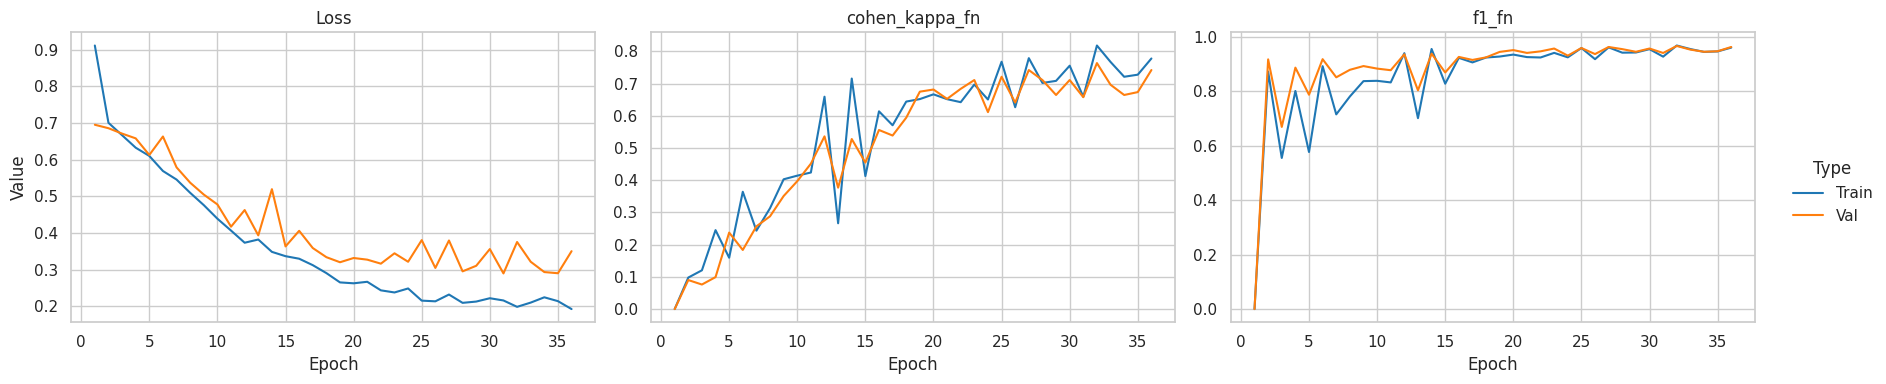

In [36]:
trainer_cnn_3.plot_epochs()

In [37]:
trainer_cnn_3.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.2405 | Test cohen_kappa_fn: 0.7578 | Test f1_fn: 0.9601


#### Visualization

In [38]:
visualizer_3 = Visualizer(model=trainer_cnn_3.model, device=device, labels_map=labels_map)

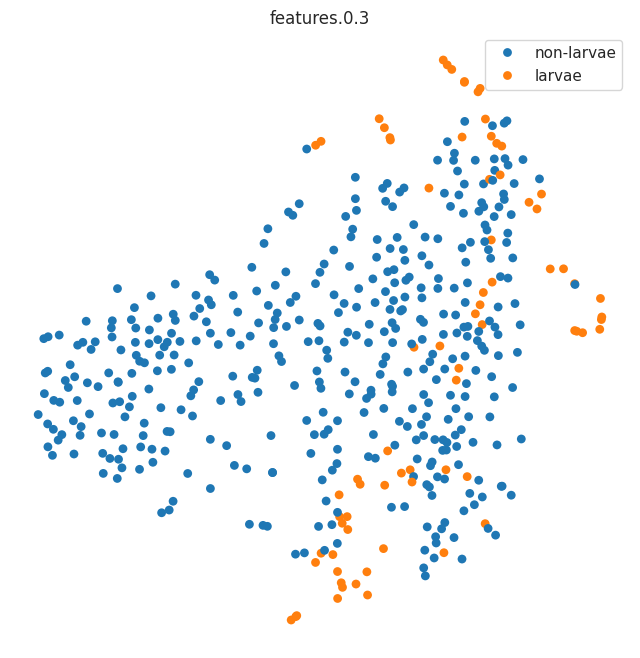

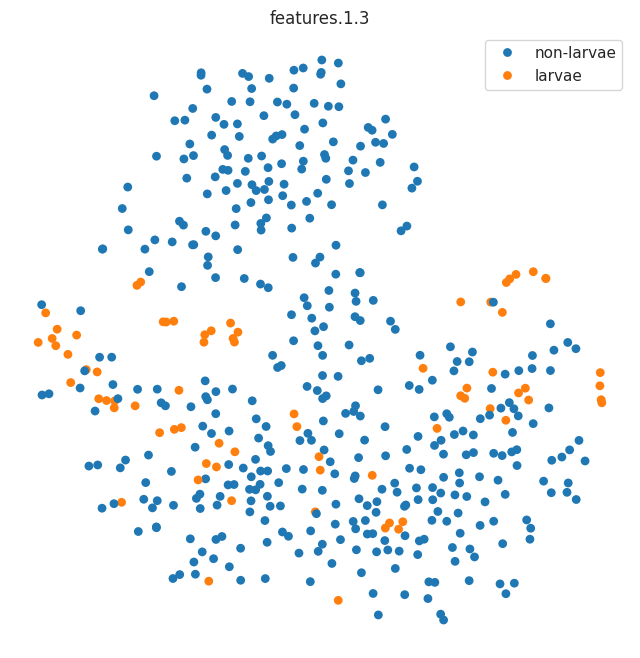

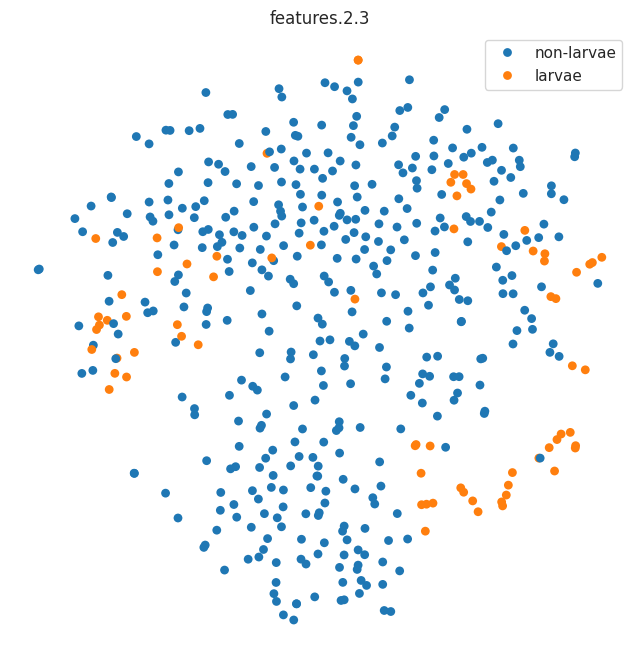

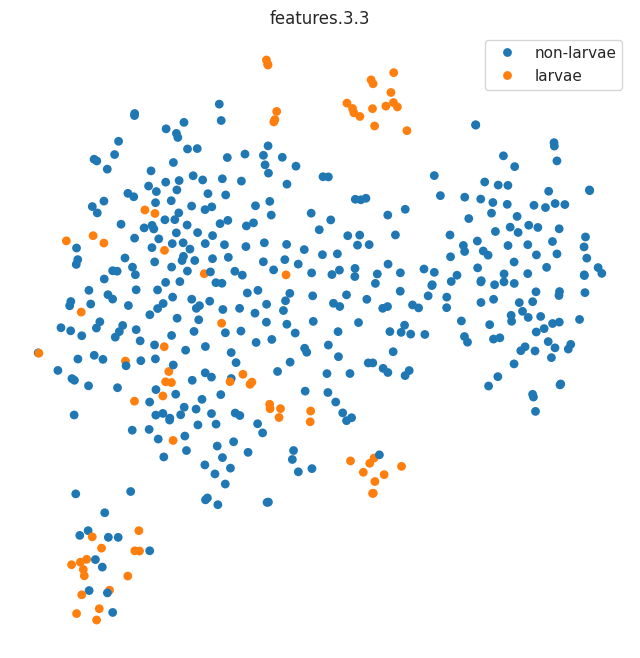

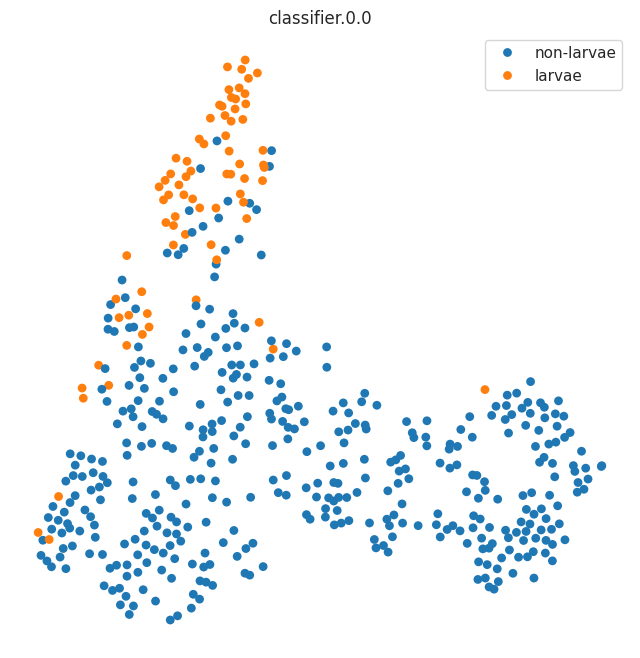

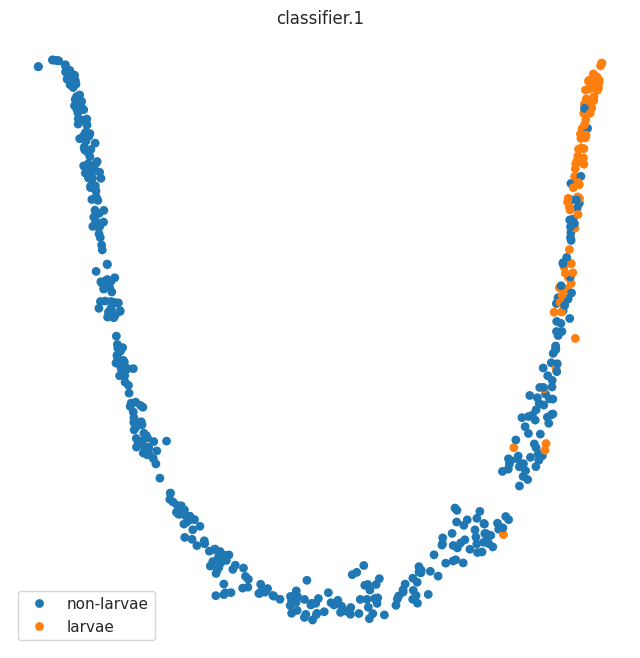

In [39]:
# Display layer representations
visualizer_3.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


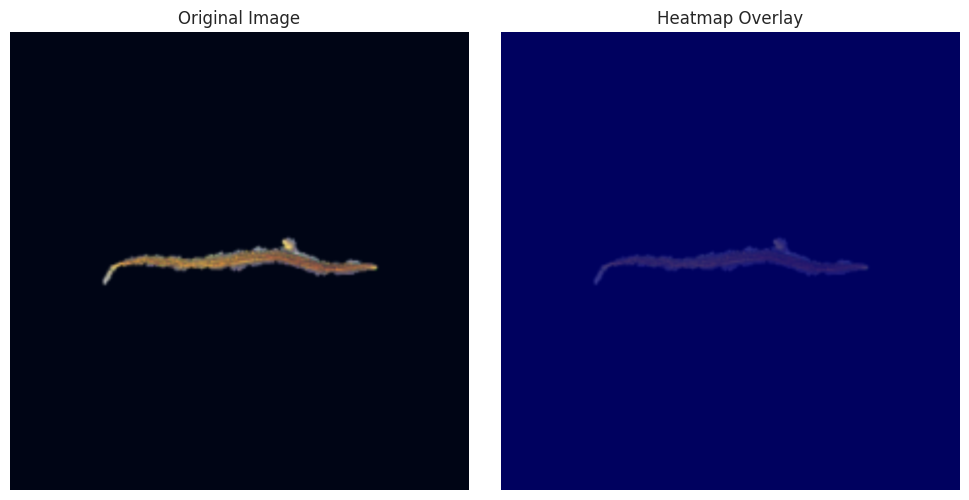

  Generating heatmap for Larvae...
  Predicted label is Larvae!


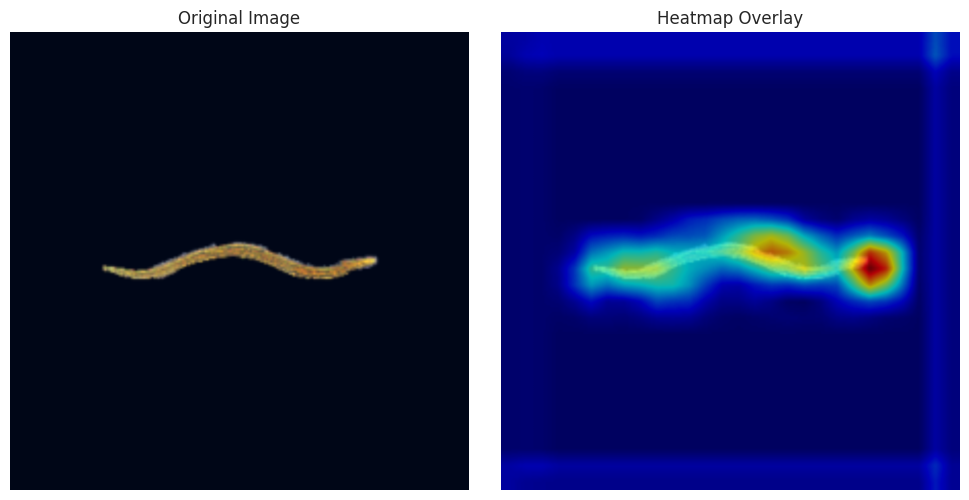

In [40]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_3.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_3.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.6. CNN4

In [41]:
cnn_4 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[128,16],
    conv_channels=[8,16,32,128],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_4, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 224, 224]             216
       BatchNorm2d-2          [-1, 8, 224, 224]              16
              ReLU-3          [-1, 8, 224, 224]               0
         MaxPool2d-4          [-1, 8, 112, 112]               0
            Conv2d-5         [-1, 16, 112, 112]           1,152
       BatchNorm2d-6         [-1, 16, 112, 112]              32
              ReLU-7         [-1, 16, 112, 112]               0
         MaxPool2d-8           [-1, 16, 56, 56]               0
            Conv2d-9           [-1, 32, 56, 56]           4,608
      BatchNorm2d-10           [-1, 32, 56, 56]              64
             ReLU-11           [-1, 32, 56, 56]               0
        MaxPool2d-12           [-1, 32, 28, 28]               0
           Conv2d-13          [-1, 128, 28, 28]          36,864
      BatchNorm2d-14          [-1, 128,

In [42]:
optimizer_cnn_4 = optim.Adam(cnn_4.parameters(), lr=2e-4)
scheduler_cnn_4 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_4, T_max=50, eta_min=1e-6)
ckpt_cnn_4 = "weights/larvae-cnn-4.pt"
trainer_cnn_4 = Trainer(
    model=cnn_4,
    optimizer=optimizer_cnn_4,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_4,
    checkpoint_path=ckpt_cnn_4,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [43]:
trainer_cnn_4.fit(train_loader, valid_loader, num_epochs=50)

❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 1 | Train Loss: 0.6936 | Val Loss: 0.6932 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 2 | Train Loss: 0.6899 | Val Loss: 0.6925 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.6855 | Val Loss: 0.6904 | Train cohen_kappa_fn: -0.0012 | Val cohen_kappa_fn: -0.0292 | Train f1_fn: 0.8986 | Val f1_fn: 0.9060
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.6808 | Val Loss: 0.6838 | Train cohen_kappa_fn: 0.1293 | Val cohen_kappa_fn: -0.1044 | Train f1_fn: 0.8614 | Val f1_fn: 0.8607
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.6666 | Val Loss: 0.6683 | Train cohen_kappa_fn: 0.1949 | Val cohen_kappa_fn: 0.0736 | Train f1_fn: 0.7745 | Val f1_fn: 0.7944
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.6430 | Val Loss: 0.6447 | Train cohen_kappa_fn: 0.1939 | Val cohen_kappa_fn: 0.1959 | Train f1_fn: 0.6435 | Val f1_fn: 0.7067
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.6144 | Val Loss: 0.6047 | Train cohen_kappa_fn: 0.2077 | Val cohen_kappa_fn: 0.2483 | Train f1_fn: 0.6654 | Val f1_fn: 0.7489
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.5742 | Val Loss: 0.5574 | Train cohen_kappa_fn: 0.1596 | Val cohen_kappa_fn: 0.2308 | Train f1_fn: 0.5827 | Val f1_fn: 0.6843
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.5229 | Val Loss: 0.4894 | Train cohen_kappa_fn: 0.2208 | Val cohen_kappa_fn: 0.3262 | Train f1_fn: 0.6883 | Val f1_fn: 0.7795
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.4931 | Val Loss: 0.4365 | Train cohen_kappa_fn: 0.2112 | Val cohen_kappa_fn: 0.3633 | Train f1_fn: 0.6660 | Val f1_fn: 0.7902
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.4672 | Val Loss: 0.3917 | Train cohen_kappa_fn: 0.2321 | Val cohen_kappa_fn: 0.3849 | Train f1_fn: 0.6872 | Val f1_fn: 0.8096
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.4332 | Val Loss: 0.3543 | Train cohen_kappa_fn: 0.3103 | Val cohen_kappa_fn: 0.4703 | Train f1_fn: 0.7676 | Val f1_fn: 0.8571
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.3888 | Val Loss: 0.3371 | Train cohen_kappa_fn: 0.3685 | Val cohen_kappa_fn: 0.4710 | Train f1_fn: 0.8032 | Val f1_fn: 0.8541
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.4049 | Val Loss: 0.3066 | Train cohen_kappa_fn: 0.4393 | Val cohen_kappa_fn: 0.5391 | Train f1_fn: 0.8448 | Val f1_fn: 0.8848
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.3562 | Val Loss: 0.4558 | Train cohen_kappa_fn: 0.2335 | Val cohen_kappa_fn: 0.2249 | Train f1_fn: 0.6712 | Val f1_fn: 0.6500
  ❄️ No improvement, model won't be saved!


📘 Epoch 16 | Train Loss: 0.3196 | Val Loss: 0.2688 | Train cohen_kappa_fn: 0.6795 | Val cohen_kappa_fn: 0.6726 | Train f1_fn: 0.9419 | Val f1_fn: 0.9410
  🔥 New best model saved!


📘 Epoch 17 | Train Loss: 0.2909 | Val Loss: 0.2803 | Train cohen_kappa_fn: 0.5703 | Val cohen_kappa_fn: 0.5577 | Train f1_fn: 0.9006 | Val f1_fn: 0.8970
  ❄️ No improvement, model won't be saved!


📘 Epoch 18 | Train Loss: 0.2834 | Val Loss: 0.2903 | Train cohen_kappa_fn: 0.7444 | Val cohen_kappa_fn: 0.7393 | Train f1_fn: 0.9608 | Val f1_fn: 0.9593
  ❄️ No improvement, model won't be saved!


📘 Epoch 19 | Train Loss: 0.3055 | Val Loss: 0.2721 | Train cohen_kappa_fn: 0.6173 | Val cohen_kappa_fn: 0.5850 | Train f1_fn: 0.9173 | Val f1_fn: 0.9109
  ❄️ No improvement, model won't be saved!


📘 Epoch 20 | Train Loss: 0.3039 | Val Loss: 0.3137 | Train cohen_kappa_fn: 0.4772 | Val cohen_kappa_fn: 0.4803 | Train f1_fn: 0.8595 | Val f1_fn: 0.8619
  ❄️ No improvement, model won't be saved!


📘 Epoch 21 | Train Loss: 0.2496 | Val Loss: 0.3248 | Train cohen_kappa_fn: 0.4581 | Val cohen_kappa_fn: 0.4509 | Train f1_fn: 0.8486 | Val f1_fn: 0.8475
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


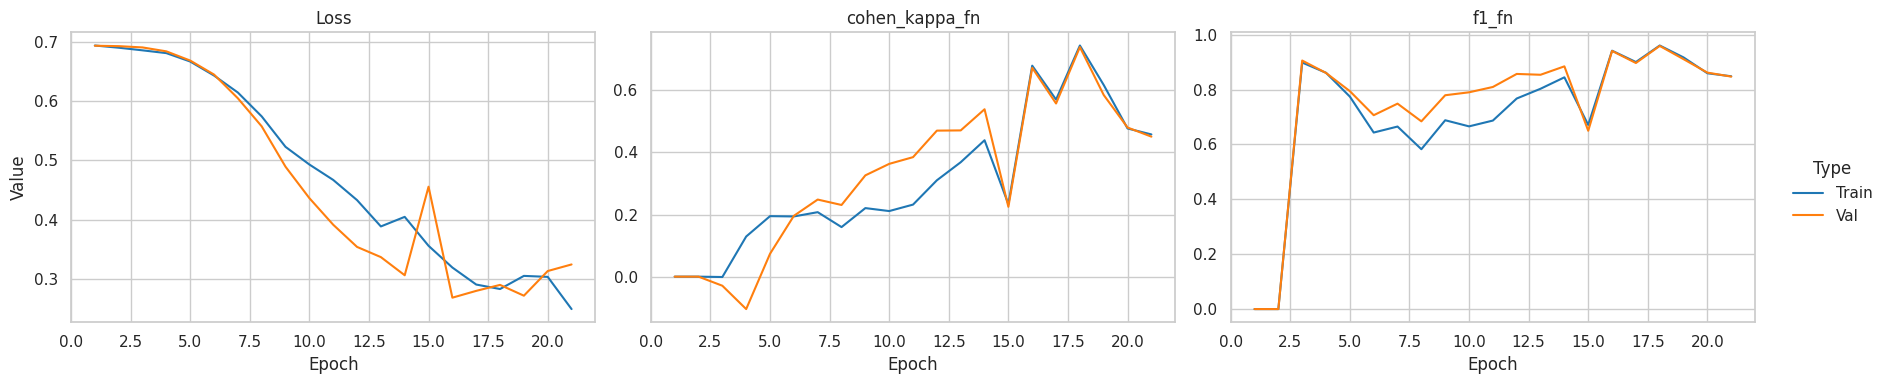

In [44]:
trainer_cnn_4.plot_epochs()

In [45]:
trainer_cnn_4.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.3169 | Test cohen_kappa_fn: 0.6332 | Test f1_fn: 0.9340


#### Visualization

In [46]:
visualizer_4 = Visualizer(model=trainer_cnn_4.model, device=device, labels_map=labels_map)

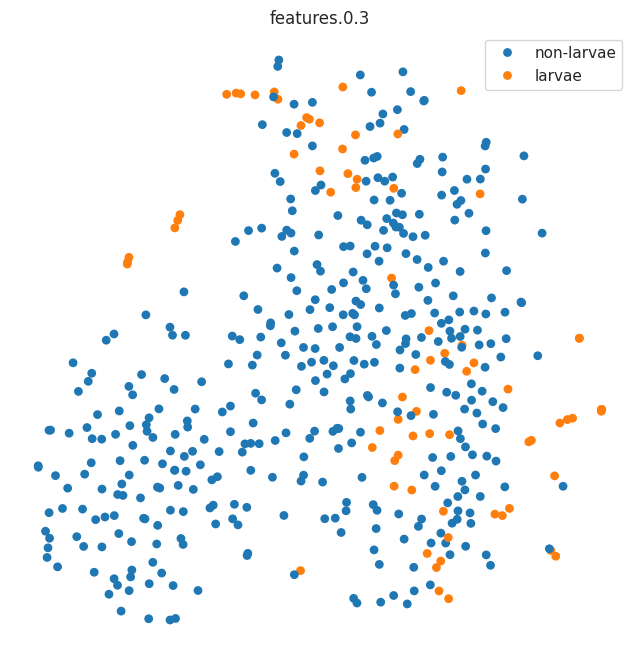

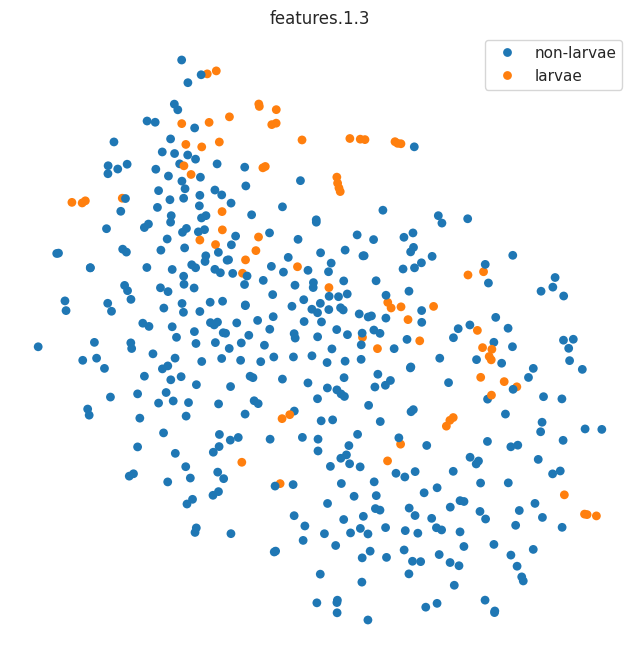

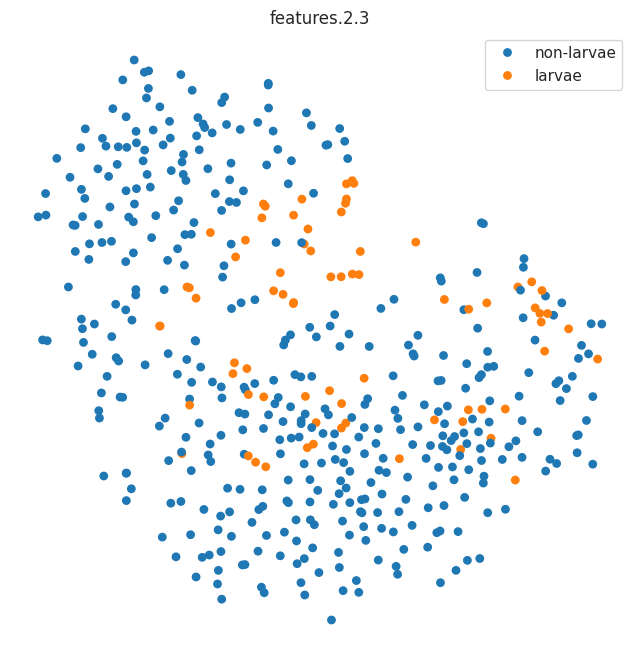

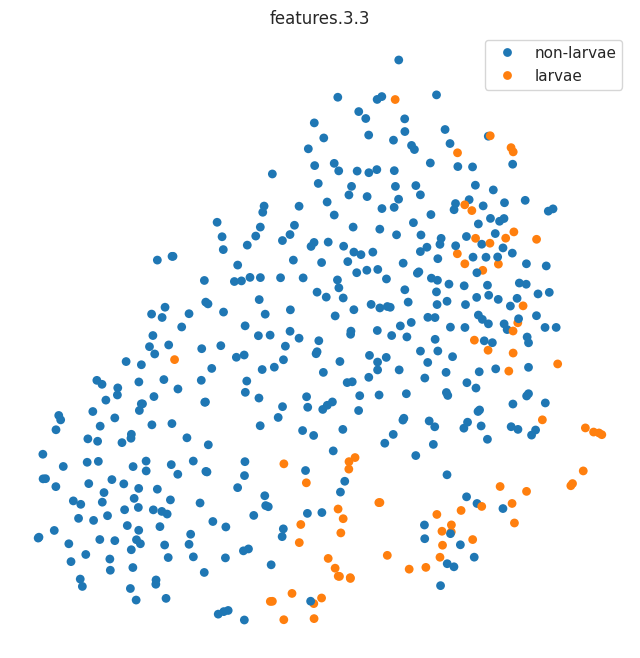

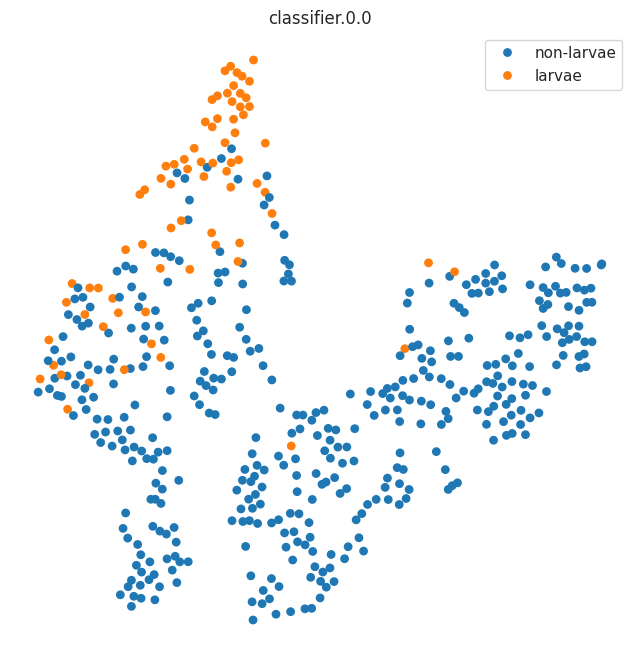

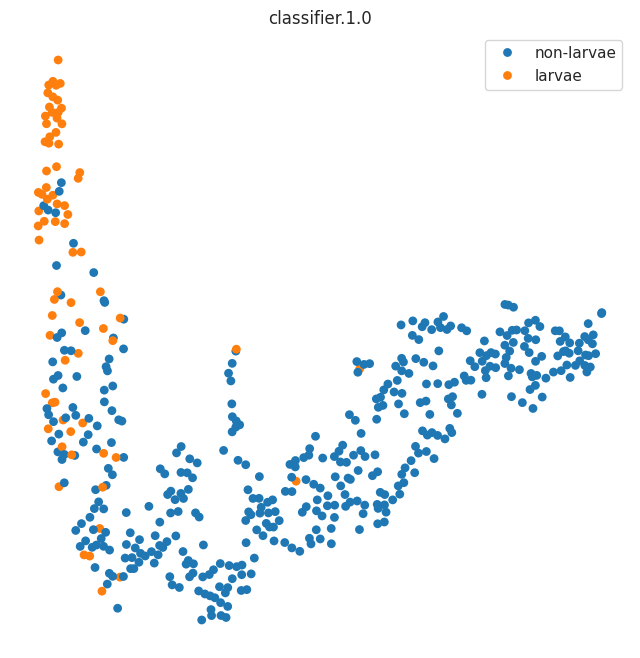

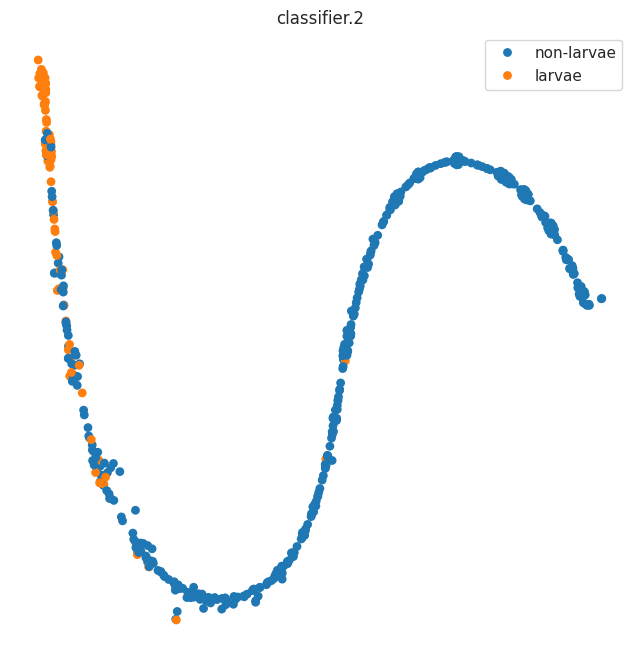

In [47]:
# Display layer representations
visualizer_4.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


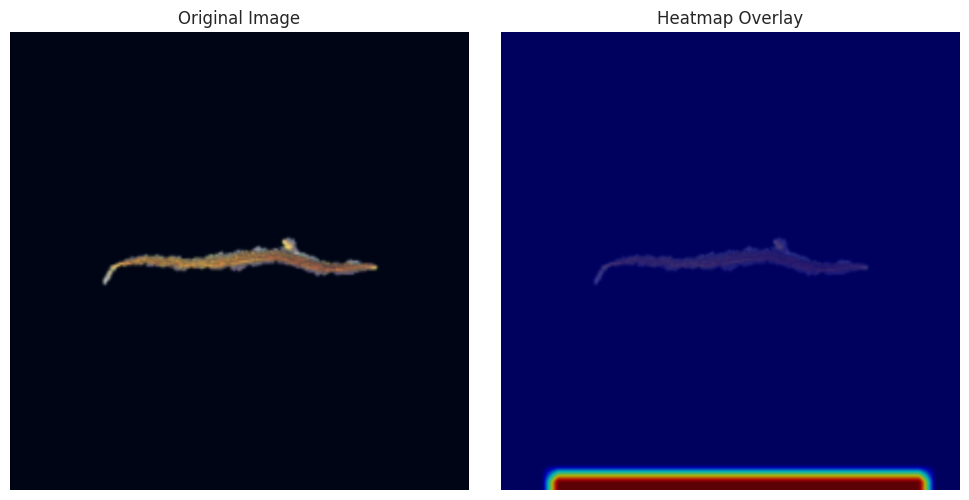

  Generating heatmap for Larvae...
  Predicted label is Non-larvae!


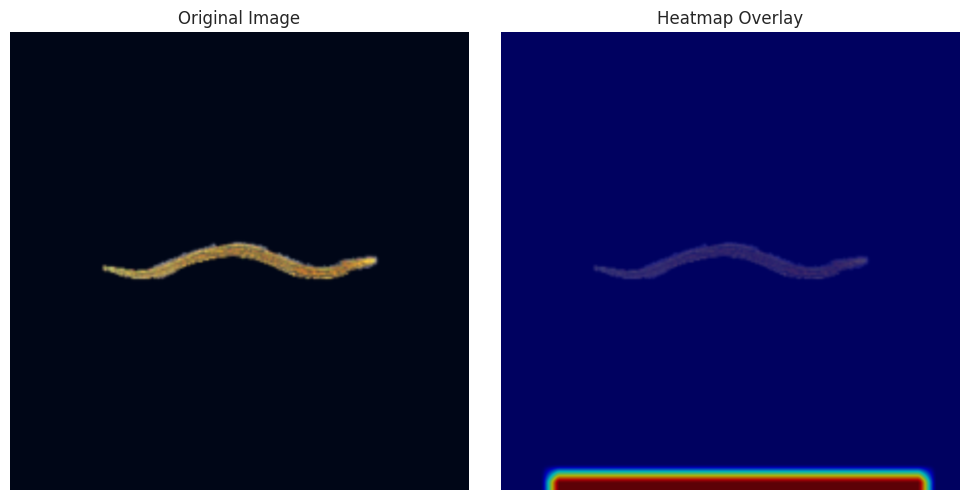

In [48]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_4.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_4.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.7. CNN5

In [49]:
cnn_5 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[128, 16],
    conv_channels=[8,16,64,256],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_5, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 224, 224]             216
       BatchNorm2d-2          [-1, 8, 224, 224]              16
              ReLU-3          [-1, 8, 224, 224]               0
         MaxPool2d-4          [-1, 8, 112, 112]               0
            Conv2d-5         [-1, 16, 112, 112]           1,152
       BatchNorm2d-6         [-1, 16, 112, 112]              32
              ReLU-7         [-1, 16, 112, 112]               0
         MaxPool2d-8           [-1, 16, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]           9,216
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13          [-1, 256, 28, 28]         147,456
      BatchNorm2d-14          [-1, 256,

In [50]:
optimizer_cnn_5 = optim.Adam(cnn_5.parameters(), lr=2e-4)
scheduler_cnn_5 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_5, T_max=50, eta_min=1e-6)
ckpt_cnn_5 = "weights/larvae-cnn-5.pt"
trainer_cnn_5 = Trainer(
    model=cnn_5,
    optimizer=optimizer_cnn_5,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_5,
    checkpoint_path=ckpt_cnn_5,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [51]:
trainer_cnn_5.fit(train_loader, valid_loader, num_epochs=50)

❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 1 | Train Loss: 0.6914 | Val Loss: 0.6924 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 2 | Train Loss: 0.6905 | Val Loss: 0.6890 | Train cohen_kappa_fn: 0.0742 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.9188 | Val f1_fn: 0.0000
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.6742 | Val Loss: 0.6775 | Train cohen_kappa_fn: 0.1504 | Val cohen_kappa_fn: 0.1579 | Train f1_fn: 0.5771 | Val f1_fn: 0.6076
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.6441 | Val Loss: 0.6461 | Train cohen_kappa_fn: 0.2028 | Val cohen_kappa_fn: 0.2349 | Train f1_fn: 0.6894 | Val f1_fn: 0.7444
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.6024 | Val Loss: 0.5928 | Train cohen_kappa_fn: 0.1712 | Val cohen_kappa_fn: 0.1741 | Train f1_fn: 0.6016 | Val f1_fn: 0.5979
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.5443 | Val Loss: 0.5547 | Train cohen_kappa_fn: 0.1621 | Val cohen_kappa_fn: 0.1450 | Train f1_fn: 0.5617 | Val f1_fn: 0.5205
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.4982 | Val Loss: 0.4409 | Train cohen_kappa_fn: 0.3279 | Val cohen_kappa_fn: 0.3709 | Train f1_fn: 0.7833 | Val f1_fn: 0.7956
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.4332 | Val Loss: 0.4090 | Train cohen_kappa_fn: 0.3055 | Val cohen_kappa_fn: 0.3469 | Train f1_fn: 0.7562 | Val f1_fn: 0.7727
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.4017 | Val Loss: 0.3315 | Train cohen_kappa_fn: 0.5711 | Val cohen_kappa_fn: 0.5812 | Train f1_fn: 0.9027 | Val f1_fn: 0.9032
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.3194 | Val Loss: 0.3158 | Train cohen_kappa_fn: 0.5060 | Val cohen_kappa_fn: 0.5443 | Train f1_fn: 0.8740 | Val f1_fn: 0.8843
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.3045 | Val Loss: 0.2651 | Train cohen_kappa_fn: 0.7132 | Val cohen_kappa_fn: 0.6431 | Train f1_fn: 0.9480 | Val f1_fn: 0.9302
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.3071 | Val Loss: 0.2537 | Train cohen_kappa_fn: 0.7148 | Val cohen_kappa_fn: 0.6583 | Train f1_fn: 0.9470 | Val f1_fn: 0.9344
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.3510 | Val Loss: 0.2727 | Train cohen_kappa_fn: 0.5764 | Val cohen_kappa_fn: 0.5563 | Train f1_fn: 0.9001 | Val f1_fn: 0.8916
  ❄️ No improvement, model won't be saved!


📘 Epoch 14 | Train Loss: 0.3364 | Val Loss: 0.2757 | Train cohen_kappa_fn: 0.7733 | Val cohen_kappa_fn: 0.7434 | Train f1_fn: 0.9625 | Val f1_fn: 0.9591
  ❄️ No improvement, model won't be saved!


📘 Epoch 15 | Train Loss: 0.2960 | Val Loss: 0.2389 | Train cohen_kappa_fn: 0.7745 | Val cohen_kappa_fn: 0.6784 | Train f1_fn: 0.9596 | Val f1_fn: 0.9382
  🔥 New best model saved!


📘 Epoch 16 | Train Loss: 0.2529 | Val Loss: 0.2351 | Train cohen_kappa_fn: 0.6630 | Val cohen_kappa_fn: 0.6453 | Train f1_fn: 0.9299 | Val f1_fn: 0.9276
  🔥 New best model saved!


📘 Epoch 17 | Train Loss: 0.2196 | Val Loss: 0.2929 | Train cohen_kappa_fn: 0.8023 | Val cohen_kappa_fn: 0.7935 | Train f1_fn: 0.9697 | Val f1_fn: 0.9687
  ❄️ No improvement, model won't be saved!


📘 Epoch 18 | Train Loss: 0.2282 | Val Loss: 0.2300 | Train cohen_kappa_fn: 0.7534 | Val cohen_kappa_fn: 0.6863 | Train f1_fn: 0.9548 | Val f1_fn: 0.9403
  🔥 New best model saved!


📘 Epoch 19 | Train Loss: 0.1994 | Val Loss: 0.2878 | Train cohen_kappa_fn: 0.7967 | Val cohen_kappa_fn: 0.7491 | Train f1_fn: 0.9680 | Val f1_fn: 0.9612
  ❄️ No improvement, model won't be saved!


📘 Epoch 20 | Train Loss: 0.2021 | Val Loss: 0.2386 | Train cohen_kappa_fn: 0.8014 | Val cohen_kappa_fn: 0.7239 | Train f1_fn: 0.9650 | Val f1_fn: 0.9529
  ❄️ No improvement, model won't be saved!


📘 Epoch 21 | Train Loss: 0.1849 | Val Loss: 0.2251 | Train cohen_kappa_fn: 0.7275 | Val cohen_kappa_fn: 0.6937 | Train f1_fn: 0.9473 | Val f1_fn: 0.9448
  🔥 New best model saved!


📘 Epoch 22 | Train Loss: 0.1689 | Val Loss: 0.3162 | Train cohen_kappa_fn: 0.8251 | Val cohen_kappa_fn: 0.7757 | Train f1_fn: 0.9725 | Val f1_fn: 0.9670
  ❄️ No improvement, model won't be saved!


📘 Epoch 23 | Train Loss: 0.2061 | Val Loss: 0.2525 | Train cohen_kappa_fn: 0.8160 | Val cohen_kappa_fn: 0.7668 | Train f1_fn: 0.9673 | Val f1_fn: 0.9628
  ❄️ No improvement, model won't be saved!


📘 Epoch 24 | Train Loss: 0.1868 | Val Loss: 0.2852 | Train cohen_kappa_fn: 0.8220 | Val cohen_kappa_fn: 0.7935 | Train f1_fn: 0.9698 | Val f1_fn: 0.9687
  ❄️ No improvement, model won't be saved!


📘 Epoch 25 | Train Loss: 0.1547 | Val Loss: 0.4342 | Train cohen_kappa_fn: 0.8485 | Val cohen_kappa_fn: 0.6997 | Train f1_fn: 0.9771 | Val f1_fn: 0.9626
  ❄️ No improvement, model won't be saved!


📘 Epoch 26 | Train Loss: 0.1685 | Val Loss: 0.2682 | Train cohen_kappa_fn: 0.8142 | Val cohen_kappa_fn: 0.7730 | Train f1_fn: 0.9683 | Val f1_fn: 0.9649
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


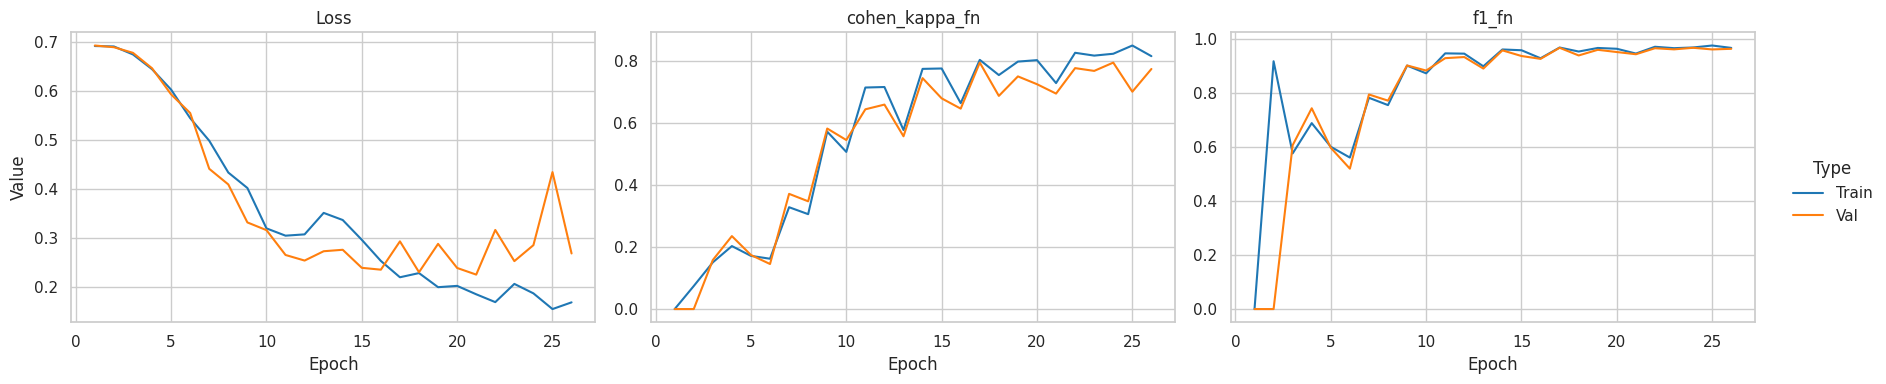

In [52]:
trainer_cnn_5.plot_epochs()

In [53]:
trainer_cnn_5.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.2053 | Test cohen_kappa_fn: 0.7924 | Test f1_fn: 0.9649


#### Visualization

In [54]:
visualizer_5 = Visualizer(model=trainer_cnn_5.model, device=device, labels_map=labels_map)

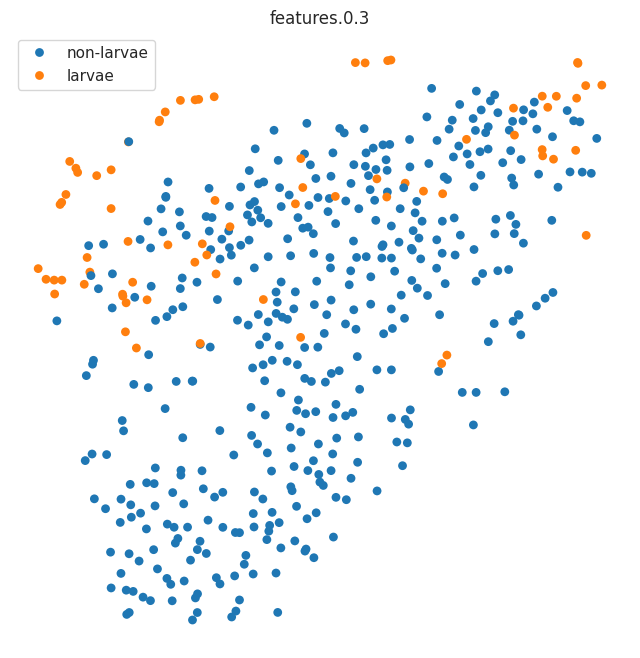

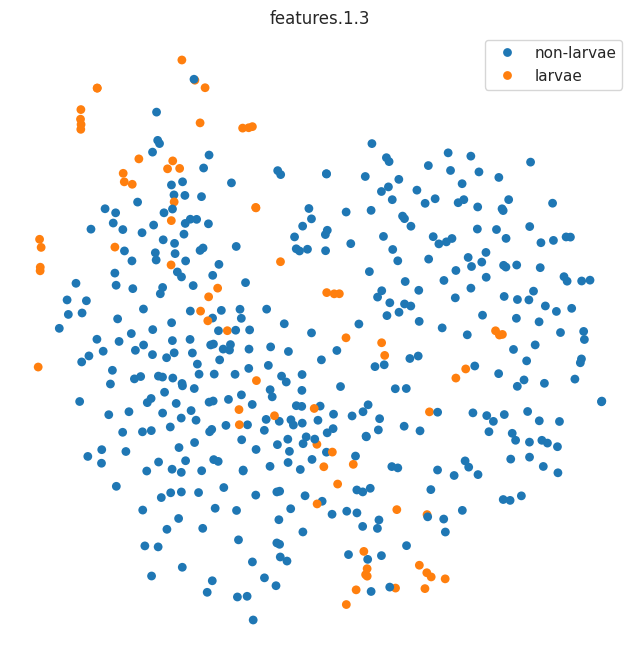

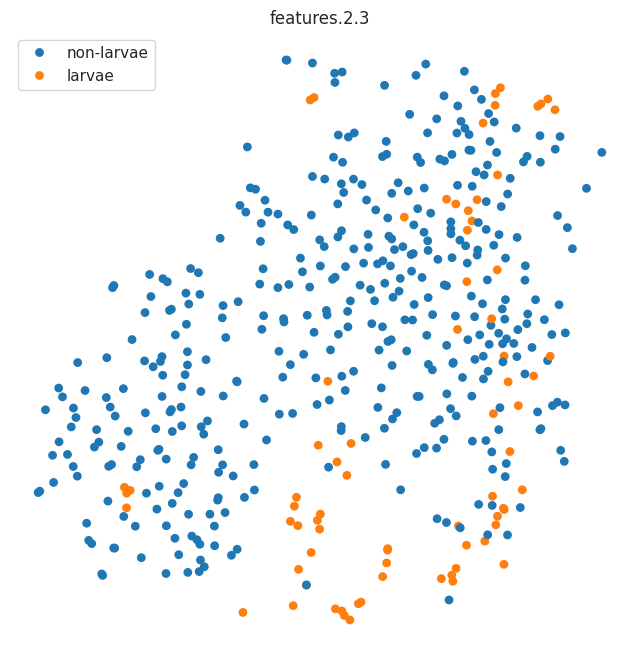

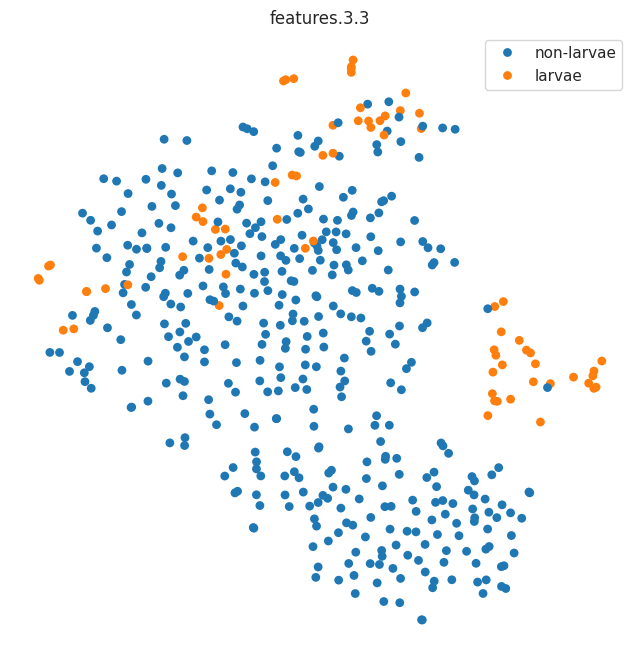

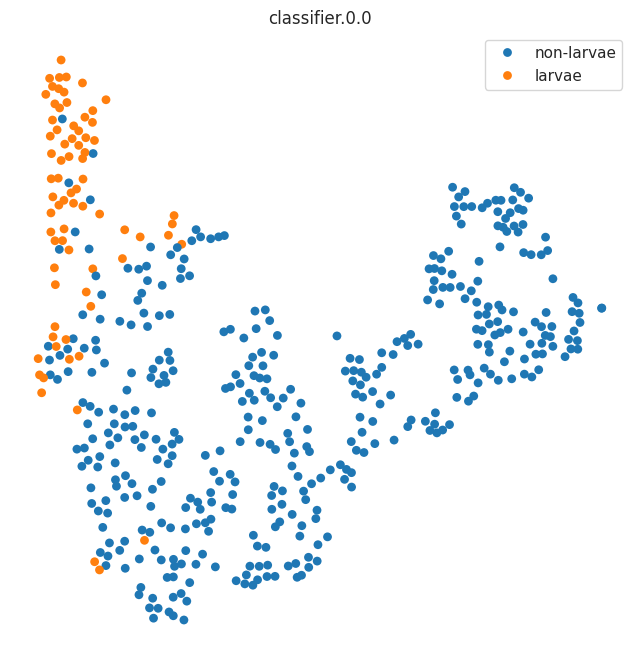

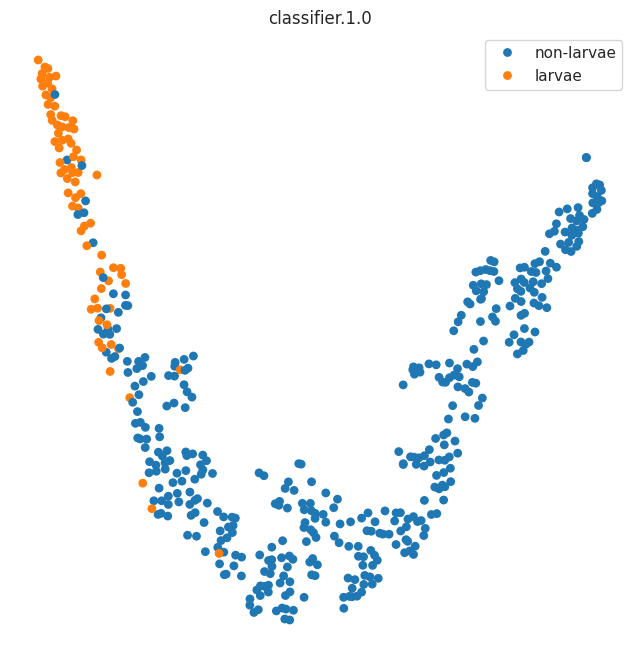

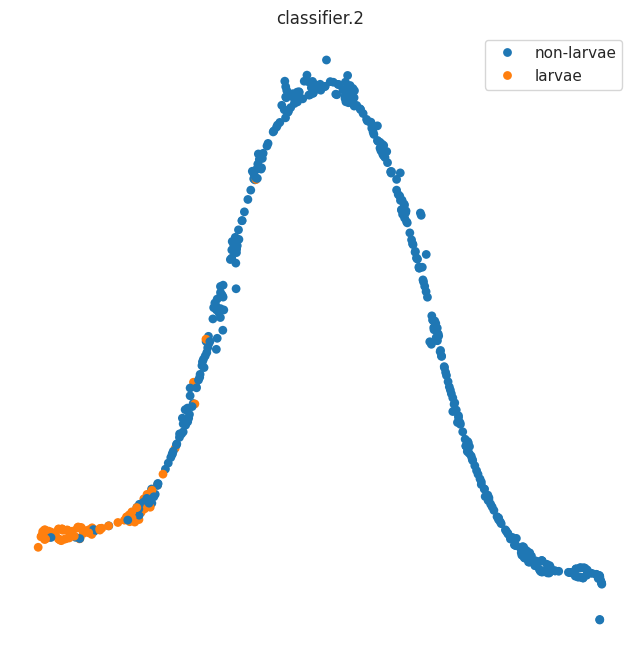

In [55]:
# Display layer representations
visualizer_5.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


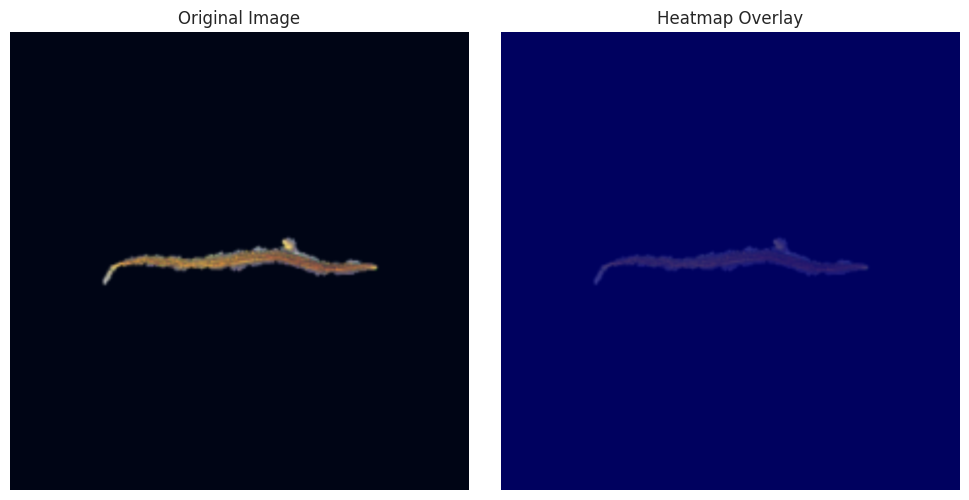

  Generating heatmap for Larvae...
  Predicted label is Larvae!


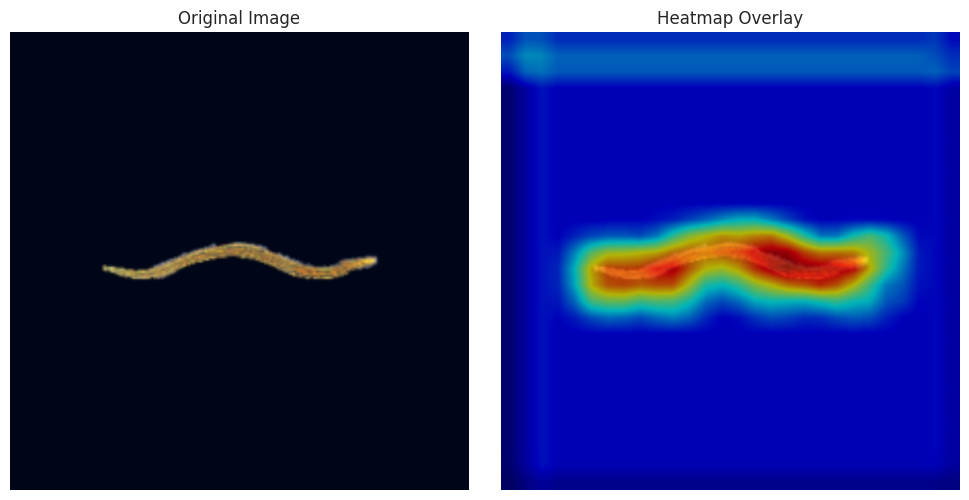

In [56]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_5.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_5.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.8. CNN6

In [57]:
cnn_6 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[128, 16],
    conv_channels=[8,16,64,256,512],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_6, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 224, 224]             216
       BatchNorm2d-2          [-1, 8, 224, 224]              16
              ReLU-3          [-1, 8, 224, 224]               0
         MaxPool2d-4          [-1, 8, 112, 112]               0
            Conv2d-5         [-1, 16, 112, 112]           1,152
       BatchNorm2d-6         [-1, 16, 112, 112]              32
              ReLU-7         [-1, 16, 112, 112]               0
         MaxPool2d-8           [-1, 16, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]           9,216
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13          [-1, 256, 28, 28]         147,456
      BatchNorm2d-14          [-1, 256,

In [58]:
optimizer_cnn_6 = optim.Adam(cnn_6.parameters(), lr=2e-4)
scheduler_cnn_6 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_6, T_max=50, eta_min=1e-6)
ckpt_cnn_6 = "weights/larvae-cnn-6.pt"
trainer_cnn_6 = Trainer(
    model=cnn_6,
    optimizer=optimizer_cnn_6,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_6,
    checkpoint_path=ckpt_cnn_6,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [59]:
trainer_cnn_6.fit(train_loader, valid_loader, num_epochs=50)

❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 1 | Train Loss: 0.6915 | Val Loss: 0.6927 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6869 | Val Loss: 0.6893 | Train cohen_kappa_fn: 0.0287 | Val cohen_kappa_fn: 0.0376 | Train f1_fn: 0.1608 | Val f1_fn: 0.2000
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.6710 | Val Loss: 0.6721 | Train cohen_kappa_fn: 0.1463 | Val cohen_kappa_fn: 0.1180 | Train f1_fn: 0.5378 | Val f1_fn: 0.4775
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.6313 | Val Loss: 0.6193 | Train cohen_kappa_fn: 0.3576 | Val cohen_kappa_fn: 0.3289 | Train f1_fn: 0.7958 | Val f1_fn: 0.7758
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.5580 | Val Loss: 0.5237 | Train cohen_kappa_fn: 0.3979 | Val cohen_kappa_fn: 0.3474 | Train f1_fn: 0.8181 | Val f1_fn: 0.7894
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.4482 | Val Loss: 0.4827 | Train cohen_kappa_fn: 0.2794 | Val cohen_kappa_fn: 0.2053 | Train f1_fn: 0.7273 | Val f1_fn: 0.6434
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.3318 | Val Loss: 0.3384 | Train cohen_kappa_fn: 0.6308 | Val cohen_kappa_fn: 0.5360 | Train f1_fn: 0.9237 | Val f1_fn: 0.9012
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.2751 | Val Loss: 0.9187 | Train cohen_kappa_fn: 0.1398 | Val cohen_kappa_fn: 0.0935 | Train f1_fn: 0.5132 | Val f1_fn: 0.3976
  ❄️ No improvement, model won't be saved!


📘 Epoch 9 | Train Loss: 0.2189 | Val Loss: 0.4147 | Train cohen_kappa_fn: 0.7762 | Val cohen_kappa_fn: 0.7361 | Train f1_fn: 0.9687 | Val f1_fn: 0.9616
  ❄️ No improvement, model won't be saved!


📘 Epoch 10 | Train Loss: 0.2388 | Val Loss: 1.1552 | Train cohen_kappa_fn: 0.1001 | Val cohen_kappa_fn: 0.0709 | Train f1_fn: 0.4192 | Val f1_fn: 0.3282
  ❄️ No improvement, model won't be saved!


📘 Epoch 11 | Train Loss: 0.2216 | Val Loss: 0.3034 | Train cohen_kappa_fn: 0.7430 | Val cohen_kappa_fn: 0.6645 | Train f1_fn: 0.9524 | Val f1_fn: 0.9389
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.2226 | Val Loss: 0.3602 | Train cohen_kappa_fn: 0.8041 | Val cohen_kappa_fn: 0.7653 | Train f1_fn: 0.9714 | Val f1_fn: 0.9651
  ❄️ No improvement, model won't be saved!


📘 Epoch 13 | Train Loss: 0.1832 | Val Loss: 0.2760 | Train cohen_kappa_fn: 0.8439 | Val cohen_kappa_fn: 0.7197 | Train f1_fn: 0.9746 | Val f1_fn: 0.9531
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.1892 | Val Loss: 0.2793 | Train cohen_kappa_fn: 0.7352 | Val cohen_kappa_fn: 0.6052 | Train f1_fn: 0.9479 | Val f1_fn: 0.9173
  ❄️ No improvement, model won't be saved!


📘 Epoch 15 | Train Loss: 0.1472 | Val Loss: 0.3269 | Train cohen_kappa_fn: 0.8342 | Val cohen_kappa_fn: 0.8115 | Train f1_fn: 0.9758 | Val f1_fn: 0.9726
  ❄️ No improvement, model won't be saved!


📘 Epoch 16 | Train Loss: 0.1690 | Val Loss: 0.2491 | Train cohen_kappa_fn: 0.8301 | Val cohen_kappa_fn: 0.7460 | Train f1_fn: 0.9704 | Val f1_fn: 0.9567
  🔥 New best model saved!


📘 Epoch 17 | Train Loss: 0.1539 | Val Loss: 0.2875 | Train cohen_kappa_fn: 0.6711 | Val cohen_kappa_fn: 0.5773 | Train f1_fn: 0.9304 | Val f1_fn: 0.9062
  ❄️ No improvement, model won't be saved!


📘 Epoch 18 | Train Loss: 0.1560 | Val Loss: 0.3126 | Train cohen_kappa_fn: 0.5833 | Val cohen_kappa_fn: 0.5226 | Train f1_fn: 0.9017 | Val f1_fn: 0.8807
  ❄️ No improvement, model won't be saved!


📘 Epoch 19 | Train Loss: 0.1440 | Val Loss: 0.2243 | Train cohen_kappa_fn: 0.8681 | Val cohen_kappa_fn: 0.7808 | Train f1_fn: 0.9773 | Val f1_fn: 0.9623
  🔥 New best model saved!


📘 Epoch 20 | Train Loss: 0.1401 | Val Loss: 0.2914 | Train cohen_kappa_fn: 0.5804 | Val cohen_kappa_fn: 0.5228 | Train f1_fn: 0.8998 | Val f1_fn: 0.8834
  ❄️ No improvement, model won't be saved!


📘 Epoch 21 | Train Loss: 0.1278 | Val Loss: 0.3124 | Train cohen_kappa_fn: 0.8654 | Val cohen_kappa_fn: 0.8255 | Train f1_fn: 0.9793 | Val f1_fn: 0.9744
  ❄️ No improvement, model won't be saved!


📘 Epoch 22 | Train Loss: 0.1212 | Val Loss: 0.2290 | Train cohen_kappa_fn: 0.8071 | Val cohen_kappa_fn: 0.7681 | Train f1_fn: 0.9648 | Val f1_fn: 0.9605
  ❄️ No improvement, model won't be saved!


📘 Epoch 23 | Train Loss: 0.1067 | Val Loss: 0.9087 | Train cohen_kappa_fn: 0.6693 | Val cohen_kappa_fn: 0.5594 | Train f1_fn: 0.9602 | Val f1_fn: 0.9489
  ❄️ No improvement, model won't be saved!


📘 Epoch 24 | Train Loss: 0.1281 | Val Loss: 0.2986 | Train cohen_kappa_fn: 0.5878 | Val cohen_kappa_fn: 0.4854 | Train f1_fn: 0.9024 | Val f1_fn: 0.8643
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


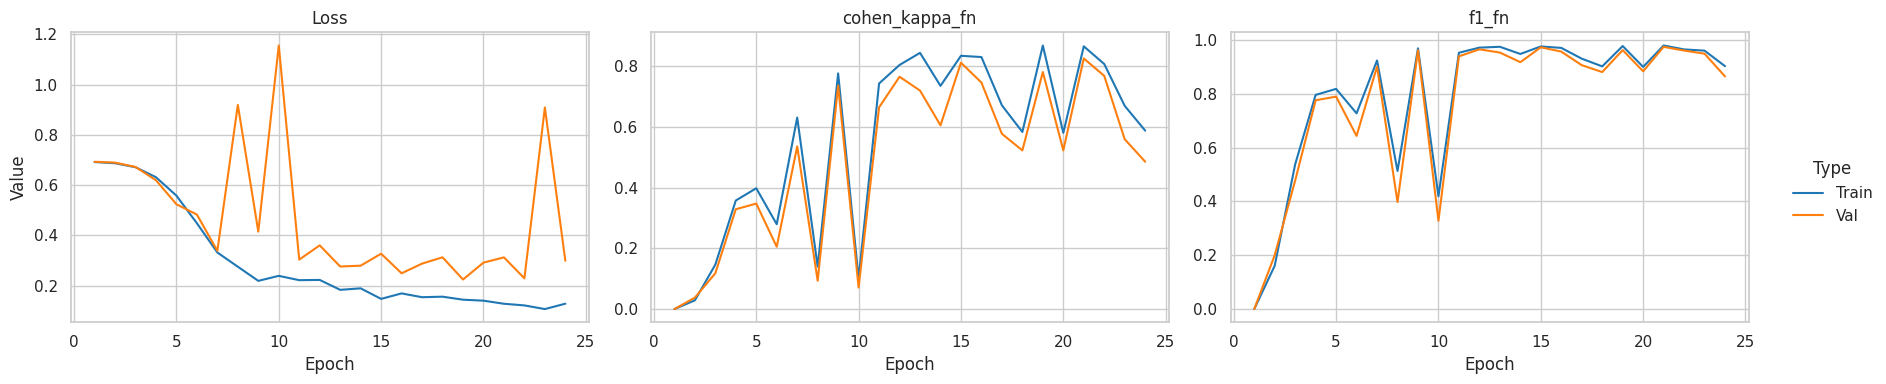

In [60]:
trainer_cnn_6.plot_epochs()

In [61]:
trainer_cnn_6.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.1765 | Test cohen_kappa_fn: 0.7602 | Test f1_fn: 0.9569


#### Visualization

In [62]:
visualizer_6 = Visualizer(model=trainer_cnn_6.model, device=device, labels_map=labels_map)

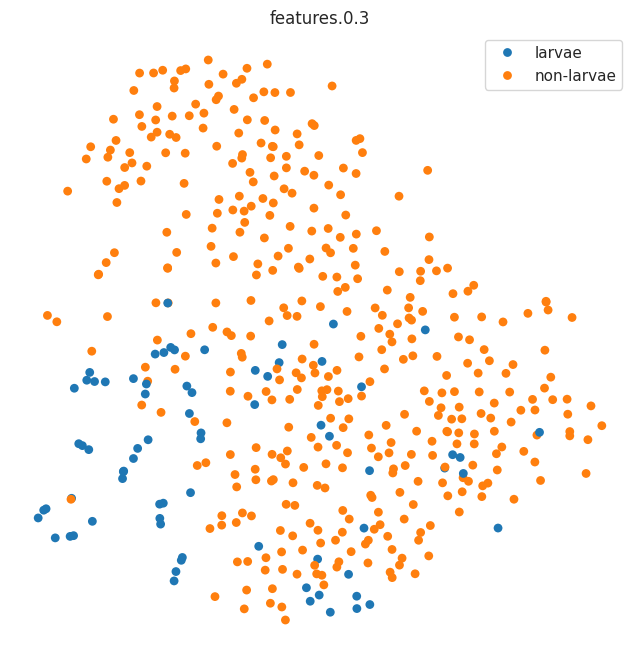

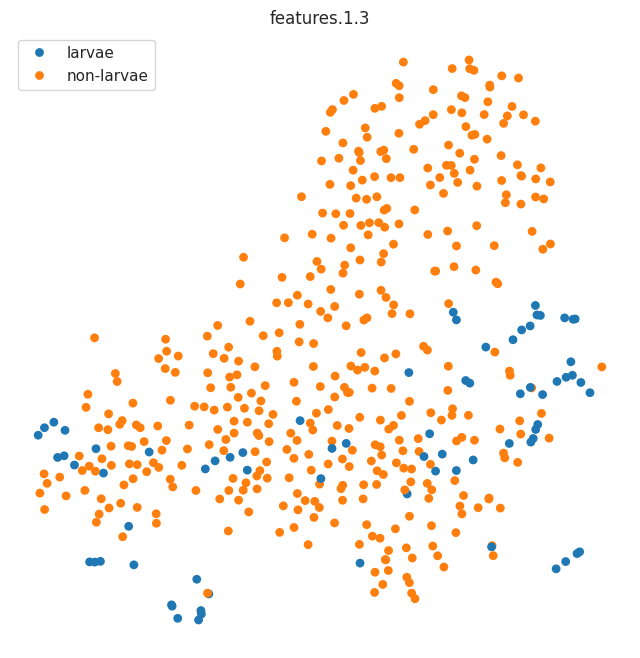

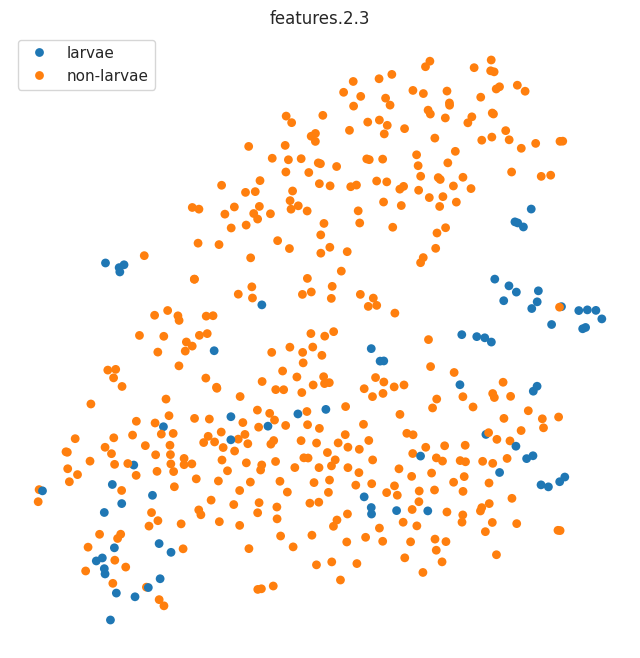

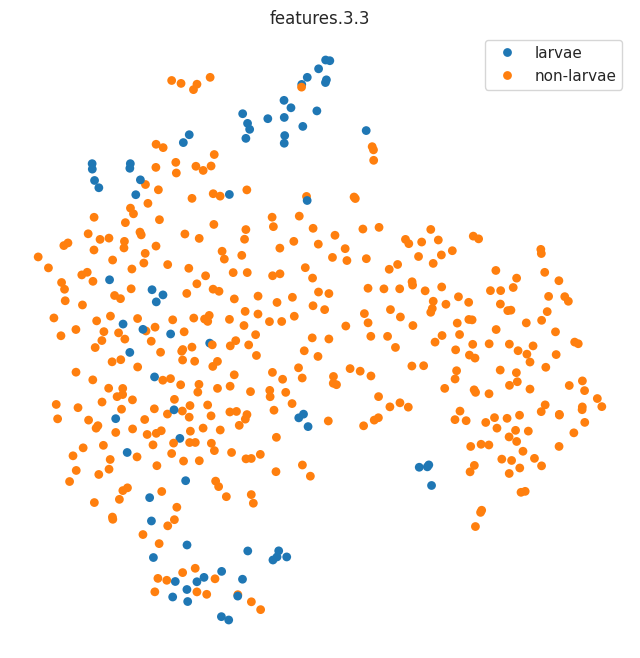

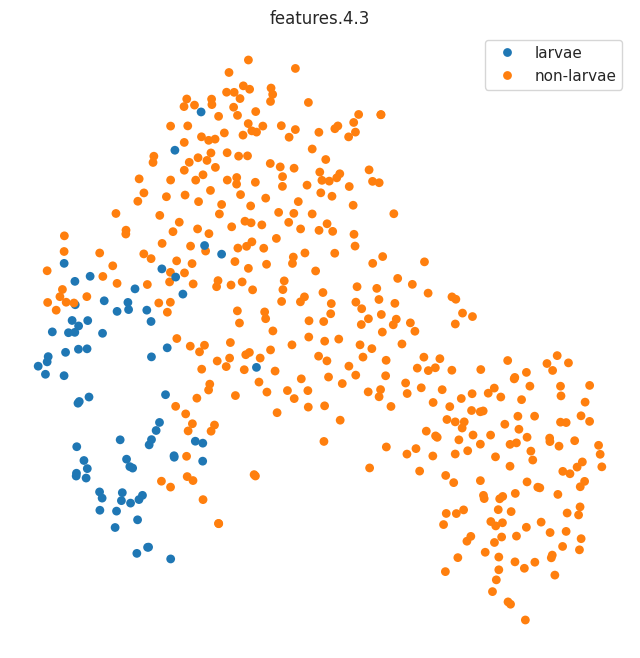

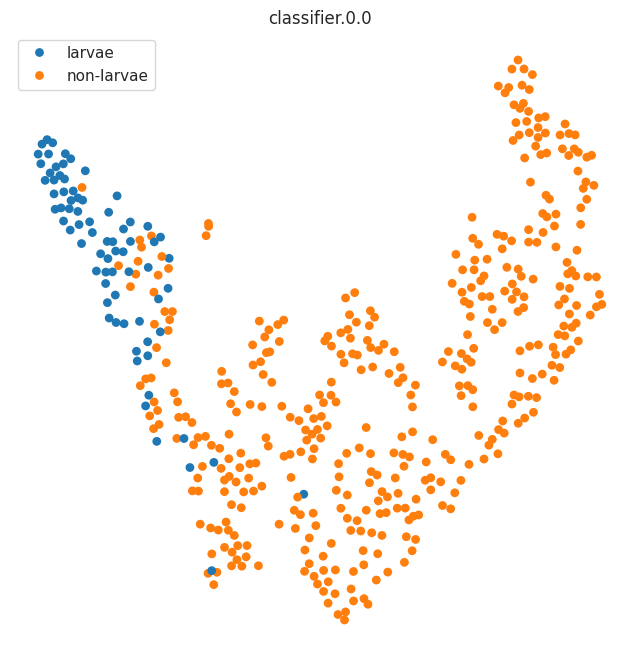

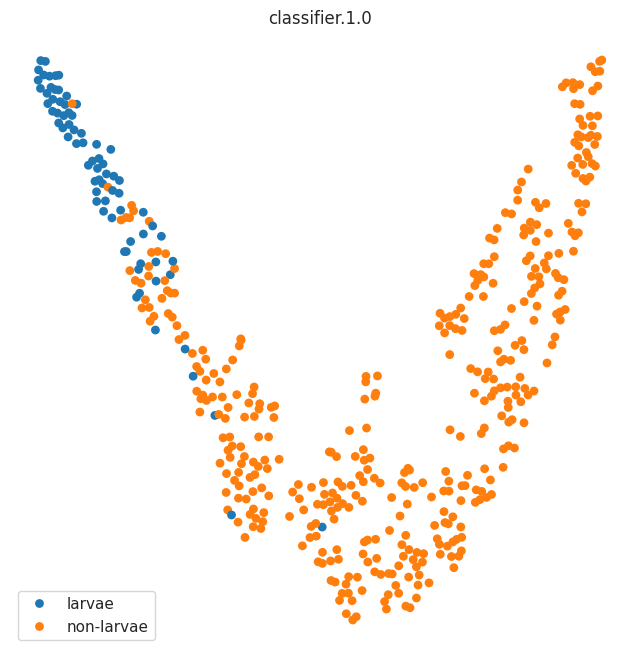

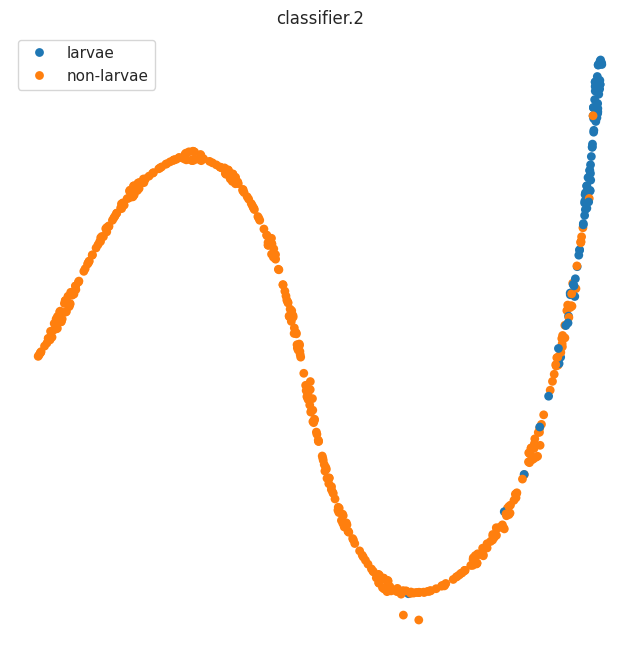

In [63]:
# Display layer representations
visualizer_6.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


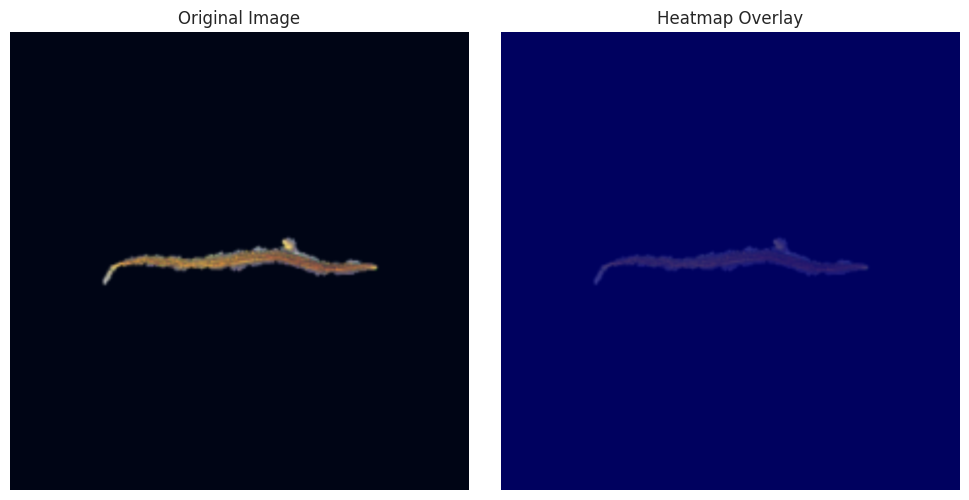

  Generating heatmap for Larvae...
  Predicted label is Larvae!


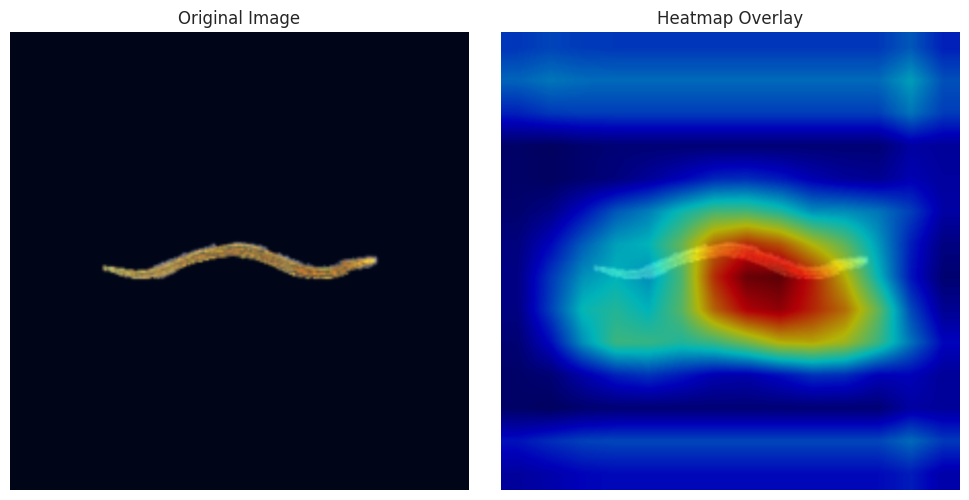

In [64]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_6.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_6.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.9. CNN7

In [65]:
cnn_7 = FlexCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    mlp_layers=[128, 16],
    conv_channels=[8,16,32,96,256],
    use_dropout=True,
    use_batchnorm=True,
    device=device,
)
summary(cnn_7, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 224, 224]             216
       BatchNorm2d-2          [-1, 8, 224, 224]              16
              ReLU-3          [-1, 8, 224, 224]               0
         MaxPool2d-4          [-1, 8, 112, 112]               0
            Conv2d-5         [-1, 16, 112, 112]           1,152
       BatchNorm2d-6         [-1, 16, 112, 112]              32
              ReLU-7         [-1, 16, 112, 112]               0
         MaxPool2d-8           [-1, 16, 56, 56]               0
            Conv2d-9           [-1, 32, 56, 56]           4,608
      BatchNorm2d-10           [-1, 32, 56, 56]              64
             ReLU-11           [-1, 32, 56, 56]               0
        MaxPool2d-12           [-1, 32, 28, 28]               0
           Conv2d-13           [-1, 96, 28, 28]          27,648
      BatchNorm2d-14           [-1, 96,

In [66]:
optimizer_cnn_7 = optim.Adam(cnn_7.parameters(), lr=2e-4)
scheduler_cnn_7 = optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn_7, T_max=50, eta_min=1e-6)
ckpt_cnn_7 = "weights/larvae-cnn-7.pt"
trainer_cnn_7 = Trainer(
    model=cnn_7,
    optimizer=optimizer_cnn_7,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_7,
    checkpoint_path=ckpt_cnn_7,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [67]:
trainer_cnn_7.fit(train_loader, valid_loader, num_epochs=50)

📘 Epoch 1 | Train Loss: 0.6921 | Val Loss: 0.6925 | Train cohen_kappa_fn: 0.0946 | Val cohen_kappa_fn: 0.0985 | Train f1_fn: 0.4487 | Val f1_fn: 0.4820
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6869 | Val Loss: 0.6894 | Train cohen_kappa_fn: 0.1110 | Val cohen_kappa_fn: 0.0985 | Train f1_fn: 0.4945 | Val f1_fn: 0.4820
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.6718 | Val Loss: 0.6795 | Train cohen_kappa_fn: 0.2062 | Val cohen_kappa_fn: 0.1414 | Train f1_fn: 0.7243 | Val f1_fn: 0.6408
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.6415 | Val Loss: 0.6500 | Train cohen_kappa_fn: 0.2310 | Val cohen_kappa_fn: 0.1374 | Train f1_fn: 0.6859 | Val f1_fn: 0.5337
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.5828 | Val Loss: 0.6132 | Train cohen_kappa_fn: 0.2177 | Val cohen_kappa_fn: 0.1200 | Train f1_fn: 0.6514 | Val f1_fn: 0.4659
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.4967 | Val Loss: 0.6007 | Train cohen_kappa_fn: 0.1940 | Val cohen_kappa_fn: 0.0852 | Train f1_fn: 0.6184 | Val f1_fn: 0.3735
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.4261 | Val Loss: 0.5648 | Train cohen_kappa_fn: 0.2794 | Val cohen_kappa_fn: 0.1163 | Train f1_fn: 0.7214 | Val f1_fn: 0.4571
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.3735 | Val Loss: 0.9549 | Train cohen_kappa_fn: 0.0911 | Val cohen_kappa_fn: 0.0206 | Train f1_fn: 0.4019 | Val f1_fn: 0.1185
  ❄️ No improvement, model won't be saved!


📘 Epoch 9 | Train Loss: 0.3352 | Val Loss: 0.3231 | Train cohen_kappa_fn: 0.6356 | Val cohen_kappa_fn: 0.4654 | Train f1_fn: 0.9244 | Val f1_fn: 0.8547
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.3064 | Val Loss: 1.0601 | Train cohen_kappa_fn: 0.1133 | Val cohen_kappa_fn: 0.0390 | Train f1_fn: 0.4601 | Val f1_fn: 0.2060
  ❄️ No improvement, model won't be saved!


📘 Epoch 11 | Train Loss: 0.2710 | Val Loss: 0.4711 | Train cohen_kappa_fn: 0.4221 | Val cohen_kappa_fn: 0.2719 | Train f1_fn: 0.8274 | Val f1_fn: 0.7126
  ❄️ No improvement, model won't be saved!


📘 Epoch 12 | Train Loss: 0.2734 | Val Loss: 0.4031 | Train cohen_kappa_fn: 0.4716 | Val cohen_kappa_fn: 0.3200 | Train f1_fn: 0.8555 | Val f1_fn: 0.7569
  ❄️ No improvement, model won't be saved!


📘 Epoch 13 | Train Loss: 0.2476 | Val Loss: 0.5835 | Train cohen_kappa_fn: 0.3018 | Val cohen_kappa_fn: 0.2000 | Train f1_fn: 0.7371 | Val f1_fn: 0.6154
  ❄️ No improvement, model won't be saved!


📘 Epoch 14 | Train Loss: 0.1981 | Val Loss: 0.3216 | Train cohen_kappa_fn: 0.5503 | Val cohen_kappa_fn: 0.4710 | Train f1_fn: 0.8902 | Val f1_fn: 0.8541
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.1808 | Val Loss: 0.2307 | Train cohen_kappa_fn: 0.7374 | Val cohen_kappa_fn: 0.6675 | Train f1_fn: 0.9497 | Val f1_fn: 0.9339
  🔥 New best model saved!


📘 Epoch 16 | Train Loss: 0.2052 | Val Loss: 0.2862 | Train cohen_kappa_fn: 0.6338 | Val cohen_kappa_fn: 0.5278 | Train f1_fn: 0.9204 | Val f1_fn: 0.8773
  ❄️ No improvement, model won't be saved!


📘 Epoch 17 | Train Loss: 0.2275 | Val Loss: 0.5149 | Train cohen_kappa_fn: 0.3400 | Val cohen_kappa_fn: 0.2779 | Train f1_fn: 0.7720 | Val f1_fn: 0.7112
  ❄️ No improvement, model won't be saved!


📘 Epoch 18 | Train Loss: 0.2006 | Val Loss: 0.2080 | Train cohen_kappa_fn: 0.7666 | Val cohen_kappa_fn: 0.7234 | Train f1_fn: 0.9571 | Val f1_fn: 0.9506
  🔥 New best model saved!


📘 Epoch 19 | Train Loss: 0.1765 | Val Loss: 0.2102 | Train cohen_kappa_fn: 0.8398 | Val cohen_kappa_fn: 0.7836 | Train f1_fn: 0.9738 | Val f1_fn: 0.9645
  ❄️ No improvement, model won't be saved!


📘 Epoch 20 | Train Loss: 0.1727 | Val Loss: 0.1887 | Train cohen_kappa_fn: 0.8329 | Val cohen_kappa_fn: 0.7716 | Train f1_fn: 0.9713 | Val f1_fn: 0.9603
  🔥 New best model saved!


📘 Epoch 21 | Train Loss: 0.1500 | Val Loss: 0.2017 | Train cohen_kappa_fn: 0.7784 | Val cohen_kappa_fn: 0.7398 | Train f1_fn: 0.9594 | Val f1_fn: 0.9522
  ❄️ No improvement, model won't be saved!


📘 Epoch 22 | Train Loss: 0.1502 | Val Loss: 0.1895 | Train cohen_kappa_fn: 0.8508 | Val cohen_kappa_fn: 0.7740 | Train f1_fn: 0.9752 | Val f1_fn: 0.9625
  ❄️ No improvement, model won't be saved!


📘 Epoch 23 | Train Loss: 0.1800 | Val Loss: 0.1773 | Train cohen_kappa_fn: 0.8063 | Val cohen_kappa_fn: 0.7775 | Train f1_fn: 0.9658 | Val f1_fn: 0.9624
  🔥 New best model saved!


📘 Epoch 24 | Train Loss: 0.1294 | Val Loss: 0.1712 | Train cohen_kappa_fn: 0.7916 | Val cohen_kappa_fn: 0.7484 | Train f1_fn: 0.9617 | Val f1_fn: 0.9542
  🔥 New best model saved!


📘 Epoch 25 | Train Loss: 0.1498 | Val Loss: 0.1569 | Train cohen_kappa_fn: 0.8123 | Val cohen_kappa_fn: 0.7749 | Train f1_fn: 0.9665 | Val f1_fn: 0.9602
  🔥 New best model saved!


📘 Epoch 26 | Train Loss: 0.1346 | Val Loss: 0.2432 | Train cohen_kappa_fn: 0.5907 | Val cohen_kappa_fn: 0.5690 | Train f1_fn: 0.9044 | Val f1_fn: 0.8988
  ❄️ No improvement, model won't be saved!


📘 Epoch 27 | Train Loss: 0.1470 | Val Loss: 0.1679 | Train cohen_kappa_fn: 0.8475 | Val cohen_kappa_fn: 0.7997 | Train f1_fn: 0.9735 | Val f1_fn: 0.9662
  ❄️ No improvement, model won't be saved!


📘 Epoch 28 | Train Loss: 0.1357 | Val Loss: 0.1766 | Train cohen_kappa_fn: 0.6947 | Val cohen_kappa_fn: 0.7350 | Train f1_fn: 0.9371 | Val f1_fn: 0.9500
  ❄️ No improvement, model won't be saved!


📘 Epoch 29 | Train Loss: 0.1252 | Val Loss: 0.1858 | Train cohen_kappa_fn: 0.8772 | Val cohen_kappa_fn: 0.8001 | Train f1_fn: 0.9797 | Val f1_fn: 0.9685
  ❄️ No improvement, model won't be saved!


📘 Epoch 30 | Train Loss: 0.1267 | Val Loss: 0.1661 | Train cohen_kappa_fn: 0.7549 | Val cohen_kappa_fn: 0.7606 | Train f1_fn: 0.9527 | Val f1_fn: 0.9560
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


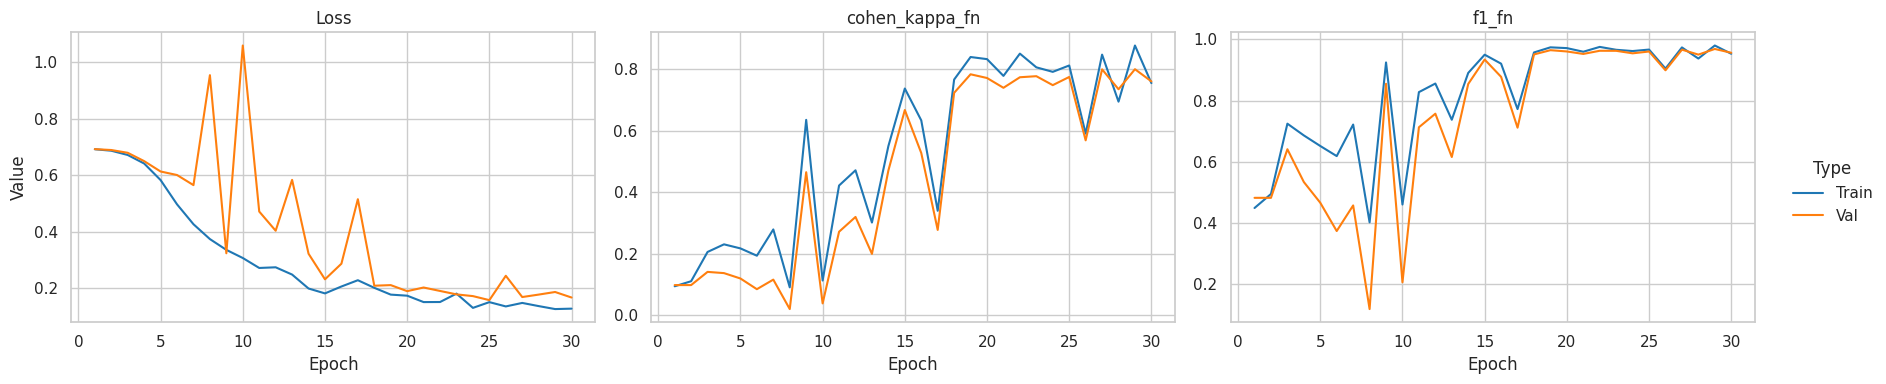

In [68]:
trainer_cnn_7.plot_epochs()

In [69]:
trainer_cnn_7.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.1444 | Test cohen_kappa_fn: 0.7786 | Test f1_fn: 0.9592


#### Visualization

In [70]:
visualizer_7 = Visualizer(model=trainer_cnn_7.model, device=device, labels_map=labels_map)

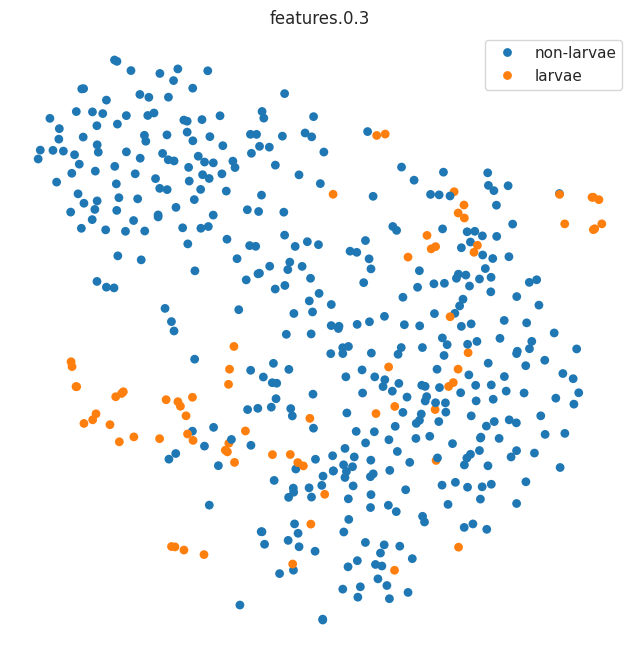

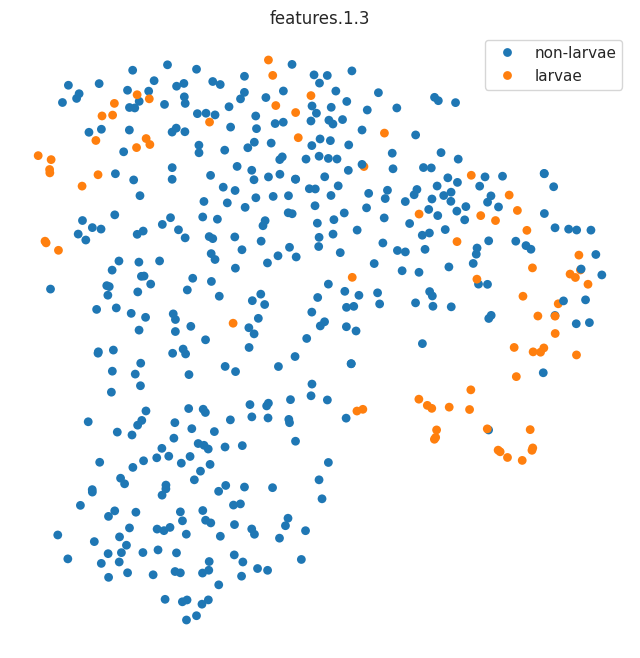

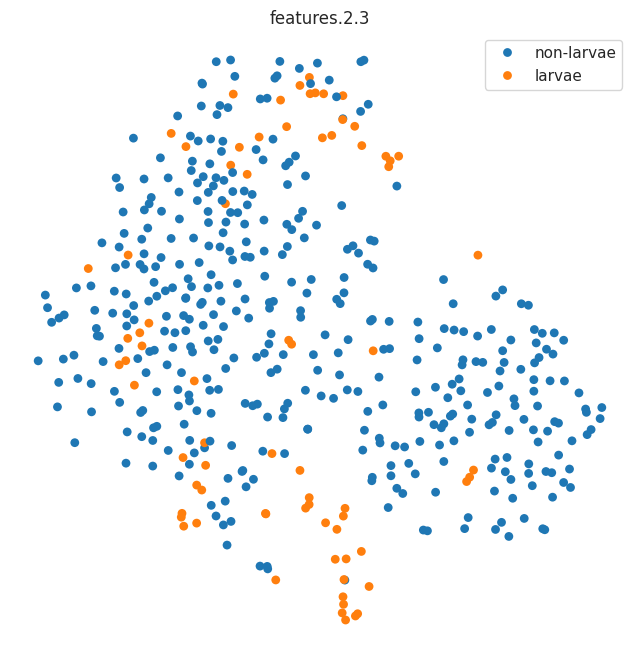

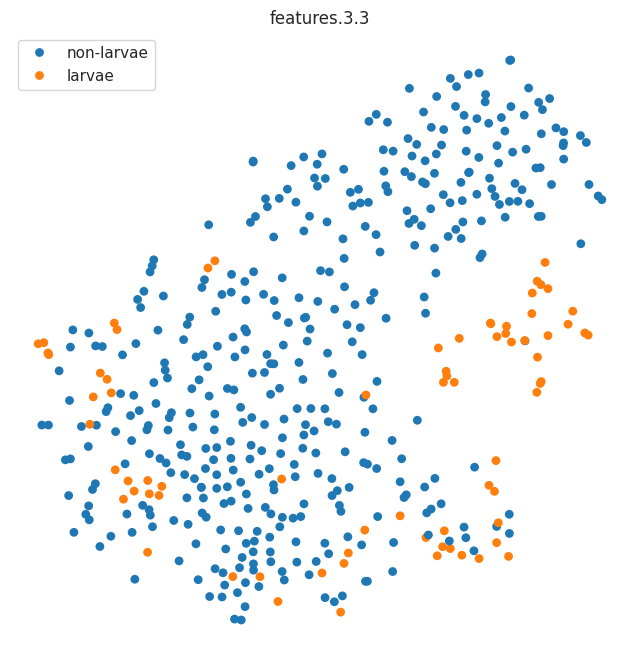

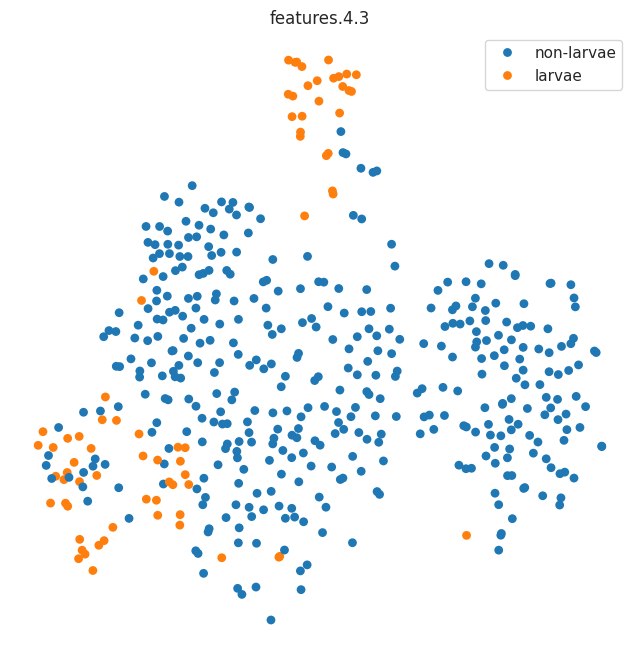

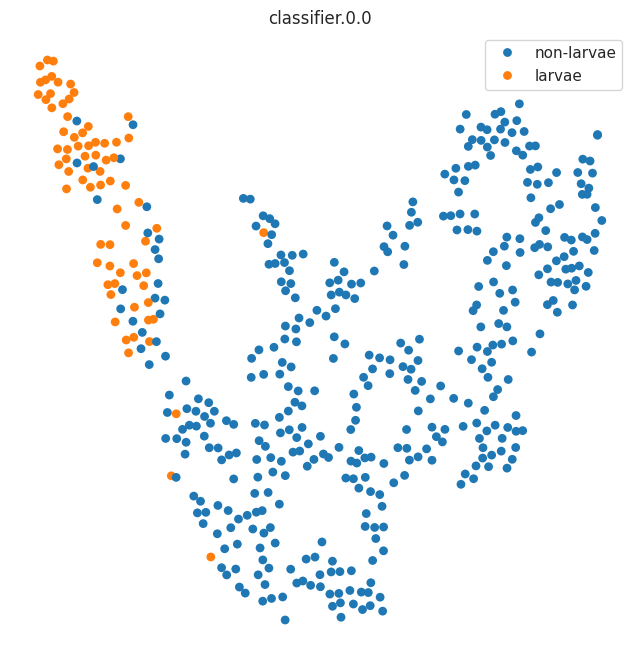

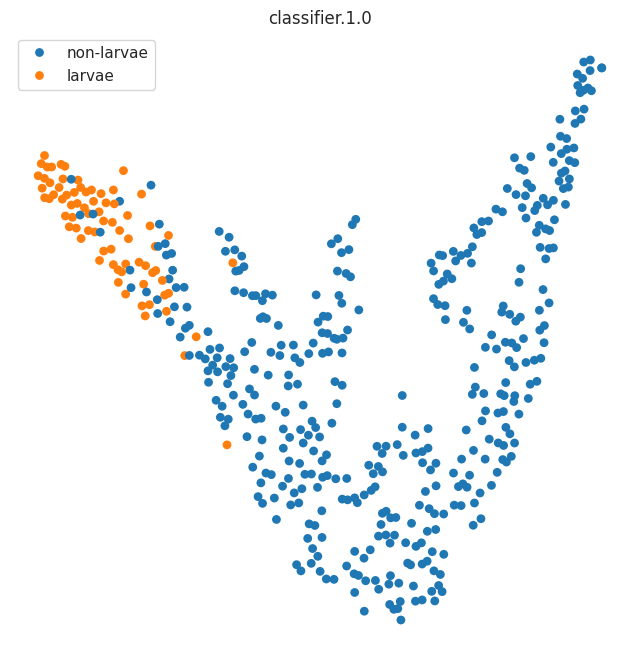

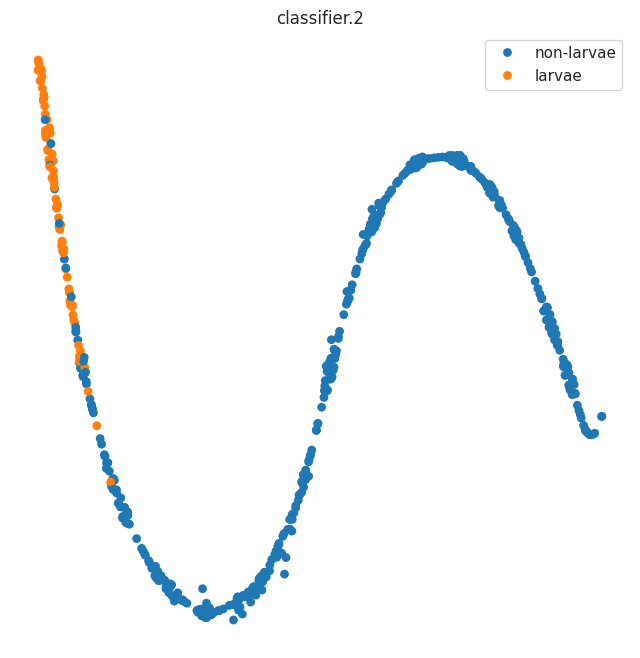

In [71]:
# Display layer representations
visualizer_7.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


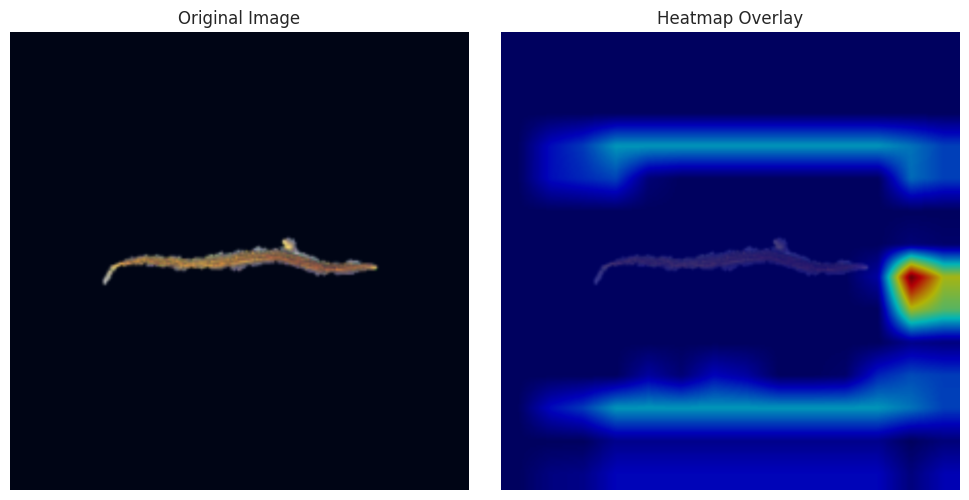

  Generating heatmap for Larvae...
  Predicted label is Larvae!


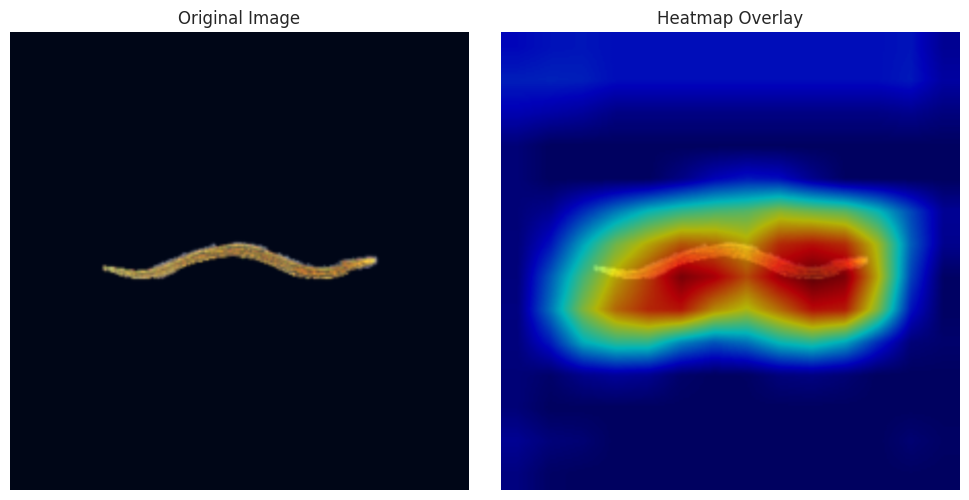

In [72]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_7.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_7.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break